ENV.

in here we define what objects we generate.

for demonstration the env consists of generating emotes.

each face has a frown or smile, 2 eyebrows each one can either high or low.




we define the reward as well -

a face with a smile: 2 reward

a face with a frown: 1 reward

and an invalid face, for example a face with a frown and a smile will have 0 reward.

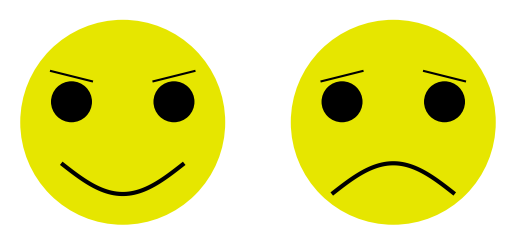

In [ ]:
import matplotlib.pyplot as pp
import numpy as np
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

In [ ]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return 0
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return 0
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return 2
  if 'frown' in face:
    return 1  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return 0


# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return torch.tensor([i in face for i in sorted_keys]).float()


# for gflownet
def face_parents(state):
  parent_states = []  # states that are parents of state
  parent_actions = []  # actions that lead from those parents to state
  for face_part in state:
    # For each face part, there is a parent without that part
    parent_states.append([i for i in state if i != face_part])
    # The action to get there is the corresponding index of that face part
    parent_actions.append(sorted_keys.index(face_part))
  return parent_states, parent_actions


PPO

here we train the PPO.

once it converges we will expect to get faces with high reward but not very diverse at all.

In [ ]:
import torch
import torch.nn as nn
import tqdm
from torch.distributions import Categorical

# Helper: mask out invalid actions (features already in the face)
def get_action_mask(current_state):
    # Simple mask: can't choose features already in the face
    return [key not in current_state for key in sorted_keys]

# === PPO Model Definition ===
class PPO(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Shared layers extract features from the state
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Policy head (formerly "actor")
        self.policy_head = nn.Linear(hidden_dim, output_dim)
        # Zero-init so policy starts near uniform
        nn.init.zeros_(self.policy_head.weight)
        nn.init.zeros_(self.policy_head.bias)

        # Value head (formerly "critic")
        self.value_head = nn.Linear(hidden_dim, 1)
        # Zero-init so value starts near zero
        nn.init.zeros_(self.value_head.weight)
        nn.init.zeros_(self.value_head.bias)

    def forward(self, x):
        shared_out = self.shared(x)
        # Return raw logits and value estimate
        return self.policy_head(shared_out), self.value_head(shared_out)

training function

In [ ]:
# === PPO Training Function ===
def train_ppo(batch_states, batch_actions, batch_old_log_probs, batch_rewards):
    # Convert lists of states/actions/log_probs/rewards to tensors
    states = torch.stack([face_to_tensor(s) for s in batch_states])
    actions = torch.tensor(batch_actions)
    old_log_probs = torch.tensor(batch_old_log_probs)
    rewards = torch.tensor(batch_rewards)

    # 1) Compute discounted returns
    returns = []
    discounted = 0
    for r in reversed(batch_rewards):
        discounted = r + GAMMA * discounted
        returns.insert(0, discounted)
    returns = torch.tensor(returns).float()

    # 2) Normalize returns to stabilize learning
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # PPO does multiple epochs over the same data
    for _ in range(K_EPOCHS):  # === PPO: multiple epochs per batch ===
        logits, values = ppo_model(states)
        values = values.squeeze()

        # === PPO: apply action mask so invalid moves get -inf logit ===
        masked_logits = logits.clone()
        for i, s in enumerate(batch_states):
            for j, key in enumerate(sorted_keys):
                if key in s:
                    masked_logits[i, j] = -1e8

        # 3) Recompute log-probs under current policy
        dist = Categorical(logits=masked_logits)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()  # exploration bonus

        # === PPO: probability ratios for clipped surrogate ===
        ratios = torch.exp(log_probs - old_log_probs.detach())

        # Advantage estimate: return minus value baseline
        advantages = returns - values.detach()

        # PPO clipped objective
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - EPS_CLIP, 1 + EPS_CLIP) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        # Critic loss: mean squared error on value estimates
        critic_loss = 0.5 * (returns - values).pow(2).mean()

        # Full loss with entropy bonus
        loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

        # Gradient step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

training

In [ ]:
# === Main Training Loop ===
batch_states = []
batch_actions = []
batch_old_log_probs = []
batch_rewards = []

# Instantiate PPO model and optimizer
ppo_model = PPO(input_dim=6, hidden_dim=128, output_dim=6)
optimizer = torch.optim.Adam(ppo_model.parameters(), lr=3e-4)

# Hyperparameters
GAMMA = 0.99         # Discount factor
K_EPOCHS = 4         # How many times to reuse each batch
EPS_CLIP = 0.2       # Clipping parameter for PPO
BATCH_SIZE = 20      # Episodes per update
sampled_faces = []

for episode in tqdm.tqdm(range(50000), ncols=40):
    state = []
    episode_log_probs = []

    # Collect one episode of 3 steps
    for t in range(3):
        state_tensor = face_to_tensor(state)
        with torch.no_grad():
            logits, value = ppo_model(state_tensor)

            # Apply action mask before sampling
            mask = torch.tensor(get_action_mask(state))
            masked_logits = logits.clone()
            masked_logits[~mask] = -1e8

            dist = Categorical(logits=masked_logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)

        # Store data for later PPO update
        batch_states.append(state.copy())
        batch_actions.append(action.item())
        episode_log_probs.append(log_prob.item())
        state.append(sorted_keys[action.item()])

    sampled_faces.append(state)

    # Only terminal step gives reward
    reward = face_reward(state)
    batch_rewards.extend([0, 0, reward])
    batch_old_log_probs.extend(episode_log_probs)

    # When enough episodes collected, run PPO update
    if (episode + 1) % BATCH_SIZE == 0:
        train_ppo(batch_states, batch_actions, batch_old_log_probs, batch_rewards)
        batch_states = []
        batch_actions = []
        batch_old_log_probs = []
        batch_rewards = []  # Reset buffers for next batch


100%|█| 50000/50000 [01:27<00:00, 570.94


looking at the faces generated we see it converged to generate only faces with smiles.

Ratio of faces with a smile: 0.9765625
Ratio of valid faces: 0.9765625


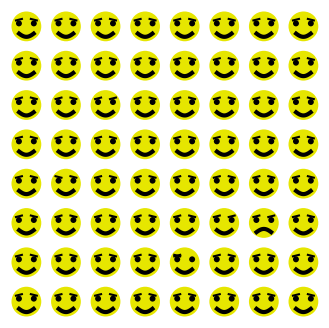

In [ ]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

MCMC

because this is a toy problem the runtime issue for mcmc is not showcased.
either way, while in bigger problems gflownet might also run longer, on generation it will be faster.
unlike mcmc which will take time until it samples smth intersting.

in addition gflownets explores better because of the neural net.
for example lets say both mcmc and gflownet discover a good object.

the gflownet because with the neural net might generalize and realize a good object and compleltly different object it can explore.

while mcmc will take a lot more time to discover that far of object as well.

100%|█| 10000/10000 [00:00<00:00, 72326.


Ratio of faces with a smile: 0.4921875
Ratio of valid faces: 1.0


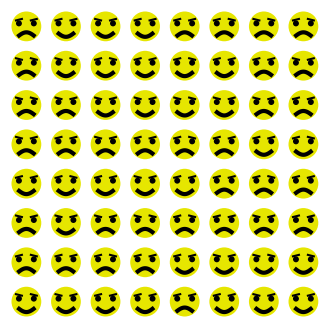

In [ ]:
import numpy as np

def propose_new_state(current_state):
    feature_type = np.random.choice(['mouth', 'left_eb', 'right_eb'])
    new_state = current_state.copy()
    if feature_type == 'mouth':
        if 'smile' in new_state:
            new_state.remove('smile')
            new_state.append('frown')
        else:
            new_state.remove('frown')
            new_state.append('smile')
    elif feature_type == 'left_eb':
        if 'left_eb_down' in new_state:
            new_state.remove('left_eb_down')
            new_state.append('left_eb_up')
        else:
            new_state.remove('left_eb_up')
            new_state.append('left_eb_down')
    elif feature_type == 'right_eb':
        if 'right_eb_down' in new_state:
            new_state.remove('right_eb_down')
            new_state.append('right_eb_up')
        else:
            new_state.remove('right_eb_up')
            new_state.append('right_eb_down')
    return new_state

def run_mcmc(initial_state, num_steps=10000, burn_in=1000):
    current_state = initial_state.copy()
    samples = []
    for _ in tqdm.tqdm(range(num_steps), ncols=40):
        proposed_state = propose_new_state(current_state)
        current_reward = face_reward(current_state)
        proposed_reward = face_reward(proposed_state)
        acceptance_prob = min(1, proposed_reward / current_reward)
        if np.random.rand() < acceptance_prob:
            current_state = proposed_state.copy()
        if _ >= burn_in:
            samples.append(current_state.copy())
    return samples

# Initial valid state
initial_state = ['smile', 'left_eb_down', 'right_eb_down']
mcmc_samples = run_mcmc(initial_state)

# Plot results
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in mcmc_samples[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in mcmc_samples[-128:]]) / 128)
for i, face in enumerate(mcmc_samples[-64:]):
    pp.sca(ax[i//8,i%8])
    draw_face(face)

GFlowNet

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm


class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # We encoded the current state as binary vector, for each patch the associated
    # dimension is either 0 or 1 depending on the absence or precense of that patch.
    # Therefore the input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(6, num_hid), nn.LeakyReLU(),
                             # We also output 6 numbers, since there are up to
                             # 6 possible actions (and thus child states), but we
                             # will mask those outputs for patches that are
                             # already there.
                             nn.Linear(num_hid, 6))
  def forward(self, x):
    # We take the exponential to get positive numbers, since flows must be positive,
    # and multiply by (1 - x) to give 0 flow to actions we know we can't take
    # (in this case, x[i] is 1 if a feature is already there, so we know we
    # can't add it again).

    F = self.mlp(x).exp()
    return F

training gflownet with flow matching objective.

we would expect after training that 2/3 of the times a trajectory following the policy will give us soe kind of smiley face.
and 1/3 of the times it will give a frowning face
while invalid faces will occur 0 times.


lets check the last 64 trajectories and see the ratios.

In [ ]:
# Instantiate model and optimizer
F_sa = FlowModel(512)
opt = torch.optim.Adam(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
for episode in tqdm.tqdm(range(50000), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict F(s, a)
  edge_flow_prediction = F_sa(face_to_tensor(state))
  for t in range(3):
    # The policy is just normalizing, and gives us the probability of each action
    policy = edge_flow_prediction / edge_flow_prediction.sum()
    # Sample the action
    action = Categorical(probs=policy).sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]

    # Now we want to compute the loss, we'll first enumerate the parents
    parent_states, parent_actions = face_parents(new_state)
    # And compute the edge flows F(s, a) of each parent
    px = torch.stack([face_to_tensor(p) for p in parent_states])
    pa = torch.tensor(parent_actions).long()
    parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
    # Now we need to compute the reward and F(s, a) of the current state,
    # which is currently `new_state`
    if t == 2:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = face_reward(new_state)
      # and since there are no children to this state F(s,a) = 0 \forall a
      edge_flow_prediction = torch.zeros(6)
    else:
      # Otherwise we keep going, and compute F(s, a)
      reward = 0
      edge_flow_prediction = F_sa(face_to_tensor(new_state))

    # The loss as per the equation above
    flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
    minibatch_loss += flow_mismatch  # Accumulate
    # Continue iterating
    state = new_state

  # We're done with the episode, add the face to the list, and if we are at an
  # update episode, take a gradient step.
  sampled_faces.append(state)
  if episode % update_freq == 0:
    losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0


100%|█| 50000/50000 [03:14<00:00, 256.46


Ratio of faces with a smile: 0.6875
Ratio of valid faces: 0.9765625


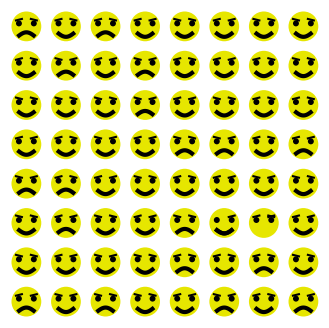

In [ ]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i) > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

a property of gflownets is that once it sufficently converged,

the "flow" in the starting state will be equal the sum of reward across all terminal states.

lets see,

here we have 4 possible faces with a smile.

and 4 possible faces with a frown.

while the rest are invalid.

because the rest are invalid they will add 0 to the total reward across terminal states.

smiles we have 4 which means we add 4*2 = 8 (2 is the reward for a smile)

frowns also 4 so we add 4*1 = 4

adding together we get 12
meaning that should be the value we are close to if the model learned well

In [ ]:
F_sa(face_to_tensor([])).sum()

tensor(11.1806, grad_fn=<SumBackward0>)

we get really close :)

In [ ]:
!pip install torch -q
!pip install torch-geometric -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00





the following is an undirected graph building env.

first you define in the innit a list of nodes types,

you then the define the maximum amount of nodes allowed.

then you pretrain you gnn which will allow you to represent a graph state as a vector.

acting in the env is easy to see in the training example below the class definition

In [ ]:
# prompt: a graph building class, only the skeleton.
# with init func, a step func,  a get parents func, to_tensor func, mask func
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GraphBuilder:
  def __init__(self, node_types, number_of_allowed_nodes):
    self.graph = nx.Graph()
    self.current_node = None
    self.node_types = node_types
    # [(node1, type1), ... (noden, type1), (node1, type2), ... (noden, type2), ....... (noden, typem)]
    self.actions = []
    for i in range(len(node_types)):
      for j in range(number_of_allowed_nodes):
        self.actions.append((j, node_types[i]))
    self.number_of_allowed_nodes = number_of_allowed_nodes
    self.number_of_allowed_nodes_backup = number_of_allowed_nodes

    self.num_of_nodes = 0
    self.types_count = {i:0 for i in node_types}
    self.visited_since_change = set()
    self.gnn_model = None
    self.hidden_dim = 10




  def trainGnn(self,
                 graph_list,
                 epochs: int = 10,
                 batch_size: int = 32,
                 hidden_dim: int = 10,
                 lr: float = 1e-3):
        """
        Pretrain the GNN encoder on a list of NetworkX graphs.
        Args:
            graph_list (List[nx.Graph]): graphs to pretrain on, each with 'node_type' attributes.
            epochs (int): number of training epochs.
            batch_size (int): batch size for DataLoader.
            hidden_dim (int): hidden dimension for GCN layers.
            lr (float): learning rate for optimizer.
        After training, self.gnn_model is frozen and used for encoding.
        """
        # 1) Convert NX graphs to PyG Data objects
        self.hidden_dim = hidden_dim
        dataset = []
        for G in graph_list:
            nodes = sorted(G.nodes())
            node_map = {old: new for new, old in enumerate(nodes)}
            N = len(nodes)
            # one-hot node type features
            x = torch.zeros((N, len(self.node_types)), dtype=torch.float)
            y = torch.zeros(N, dtype=torch.long)
            for old, data in G.nodes(data=True):
                i = node_map[old]
                t_idx = self.node_types.index(data['node_type'])
                x[i, t_idx] = 1.0
                y[i] = t_idx
            # build bidirectional edges
            edge_index = []
            for u, v in G.edges():
                ui, vi = node_map[u], node_map[v]
                edge_index += [(ui, vi), (vi, ui)]
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            dataset.append(Data(x=x, edge_index=edge_index, y=y))

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # 2) Define encoder + classifier head
        class GCNEncoder(torch.nn.Module):
            def __init__(self, in_dim, hid_dim, num_types):
                super().__init__()
                self.conv1 = GCNConv(in_dim, hid_dim)
                self.conv2 = GCNConv(hid_dim, hid_dim)
                self.classifier = torch.nn.Linear(hid_dim, num_types)

            def forward(self, x, edge_index):
                h = F.relu(self.conv1(x, edge_index))
                h = F.relu(self.conv2(h, edge_index))
                logits = self.classifier(h)
                return h, logits

        # instantiate and train
        model = GCNEncoder(len(self.node_types), hidden_dim, len(self.node_types))
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        model.train()
        for _ in range(epochs):
            for batch in loader:
                optimizer.zero_grad()
                h, logits = model(batch.x, batch.edge_index)
                loss = F.cross_entropy(logits, batch.y)
                loss.backward()
                optimizer.step()

        # freeze encoder
        self.gnn_model = model.eval()
        self.reset()




  def reset(self):
    self.graph = nx.Graph()
    self.number_of_allowed_nodes = self.number_of_allowed_nodes_backup
    self.current_node = None
    self.num_of_nodes = 0
    self.types_count = {i:0 for i in self.node_types}
    self.visited_since_change = set()




  def step(self, action):
    if action >= len(self.actions):
      raise Exception("Invalid action")

    if action not in self.graph:
      node_type = self.actions[action][1]
      self.num_of_nodes += 1
      self.types_count[node_type] += 1
      self.graph.add_node(action, node_type=node_type)

    if not (self.current_node is None) and not self.graph.has_edge(self.current_node, action):
      self.visited_since_change = {action}
      self.graph.add_edge(self.current_node, action)
    else:
      self.visited_since_change.add(action)

    self.current_node = action





  def collect_data(self, episodes=1000, bias_for_bigger_graphs=2):
    n = self.number_of_allowed_nodes
    exponent = bias_for_bigger_graphs
    data = []
    # max_clique_count = {}
    for i in range(episodes):
      self.reset()
      weights = [exponent ** i for i in range(1, n+1)]
      nodes_allowed = random.choices(range(1, n+1), weights=weights, k=1)[0]
      self.number_of_allowed_nodes = nodes_allowed
      actions = self.mask()
      while sum(actions) > 0:
        ones_indices = [i for i, val in enumerate(actions) if val == 1]
        action = random.choice(ones_indices)
        self.step(action)
        actions = self.mask()

      # max_clique = max(nx.find_cliques(self.graph), key=lambda clique: len(clique), default=[])
      # max_clique_count[len(max_clique)] = max_clique_count.get(len(max_clique), 0) + 1
      data.append(self.graph)

    # for key in max_clique_count:
    #   print(f"out of the last {episodes} graphs: {max_clique_count[key]/episodes} were clique {key} " )
    self.reset()
    return data





  def _embed_node(self, graph, target):
    """Helper: run self.gnn_model on `graph` and return embedding of `target`."""
    if self.gnn_model is None:
        raise RuntimeError("GNN model not trained.")
    nodes = sorted(graph.nodes())
    node_map = {old: new for new, old in enumerate(nodes)}
    N = len(nodes)
    x = torch.zeros((N, len(self.node_types)), dtype=torch.float)
    edges = []
    for old, data in graph.nodes(data=True):
        i = node_map[old]
        t_idx = self.node_types.index(data['node_type'])
        x[i, t_idx] = 1.0
    for u, v in graph.edges():
        edges += [(node_map[u], node_map[v]), (node_map[v], node_map[u])]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0),dtype=torch.long)
    with torch.no_grad():
        h, _ = self.gnn_model(x, edge_index)
    idx = node_map[target]
    return h[idx]




  def get_parents(self):
    """
    For each neighbor of current_node, collect embeddings:
      - No neighbors: [zero_vec]
      - One neighbor: remove current_node, embed neighbor
      - Multiple: for each neighbor n,
          (embed n in original graph,
            embed n with edge (current_node, n) removed)
    Returns: (list_of_parent_tensors, current_node)
    """
    if self.current_node is None:
        raise RuntimeError("No current node set.")
    neighs = list(self.graph.neighbors(self.current_node))
    # no neighbors
    if not neighs:
        if self.hidden_dim is None:
            raise RuntimeError("Hidden dim unknown.")
        return [torch.zeros(self.hidden_dim)], self.current_node
    parents = []
    # single neighbor
    if len(neighs) == 1:
        n = neighs[0]
        g2 = self.graph.copy()
        g2.remove_node(self.current_node)
        emb = self._embed_node(g2, n)
        parents.append(emb)
        return parents, self.current_node
    # multiple neighbors
    for n in neighs:
        # original embedding
        emb_orig = self._embed_node(self.graph, n)
        # embedding with edge removed
        g2 = self.graph.copy()
        g2.remove_edge(self.current_node, n)
        emb_pert = self._embed_node(g2, n)
        parents.append(emb_orig)
        parents.append(emb_pert)

    return parents, self.current_node





  def to_tensor(self):
    """
    Converts the current graph into a PyG Data object or returns
    the embedding of the current node. If the graph is empty (no current node),
    returns a zero-vector embedding of size hidden_dim (if encoder is ready).
    """
    # If graph empty but GNN exists, return zero embedding
    if self.current_node is None and self.gnn_model is not None:
        return torch.zeros(self.hidden_dim)

    # Build PyG Data
    nodes = sorted(self.graph.nodes())
    node_map = {old: new for new, old in enumerate(nodes)}
    self._node_map = node_map
    N = len(nodes)

    x = torch.zeros((N, len(self.node_types)), dtype=torch.float)
    edges = []
    for old, data in self.graph.nodes(data=True):
        i = node_map[old]
        t_idx = self.node_types.index(data['node_type'])
        x[i, t_idx] = 1.0
    for u, v in self.graph.edges():
        edges += [(node_map[u], node_map[v]), (node_map[v], node_map[u])]

    # Ensure edge_index is always [2, E]
    if edges:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, num_nodes=N)

    # If encoder & current node exist, return embedding
    if self.current_node is not None and self.gnn_model is not None:
        with torch.no_grad():
            h, _ = self.gnn_model(data.x, data.edge_index)
        idx = node_map[self.current_node]
        return h[idx]

    return data






  def mask(self):
    # if self.num_of_nodes == self.number_of_allowed_nodes:
    #   return [0] * self.number_of_allowed_nodes * len(self.node_types)

    how_many_to_mask = []
    for type in self.node_types:
      # exists a node that can be masked
      how_many_to_mask.append(self.num_of_nodes - self.types_count[type])

    the_resulting_mask = []

    current_type = 0
    for i in how_many_to_mask:
      if i == 0:
        the_resulting_mask += [1] * self.number_of_allowed_nodes
        current_type += 1
        continue

      type_i_nodes = []
      deleted = 0
      for j in range(self.number_of_allowed_nodes):
        if j + current_type*self.number_of_allowed_nodes in self.graph:
          type_i_nodes.append(1)
        elif deleted < i:
          type_i_nodes.append(0)
          deleted += 1
        else:
          type_i_nodes.append(1)
      the_resulting_mask += type_i_nodes
      current_type += 1

    # finishes here the resulting mask is for each type [0 as much as needs to be deleted. but cant 0 if its in the graph]
    # then add them for one mask

    if self.current_node is not None:
      the_resulting_mask[self.current_node] = 0
      for nbr in self.graph.neighbors(self.current_node):
        if nbr in self.visited_since_change:
          the_resulting_mask[nbr] = 0

    return the_resulting_mask

  def show_graph(self, graph=None):
    """Displays the current graph using matplotlib."""


    if graph is None:
        graph = self.graph
        print(self.current_node)


    pos = nx.spring_layout(graph)

    # 1) draw nodes & edges WITHOUT default labels
    nx.draw(
        graph,
        pos,
        with_labels=False,         # ← disable node‐ID labels
        node_color='lightblue',
        node_size=500,
        edge_color='gray'
    )

    # 2) fetch your node_type attrs
    node_labels = nx.get_node_attributes(graph, 'node_type')

    # 3) draw ONLY the type labels
    nx.draw_networkx_labels(
        graph,
        pos,
        labels=node_labels,
        font_color='black'
    )

    plt.axis('off')
    plt.show()

In [ ]:
# proxy

def largest_clique_score(G):

    max_clique = max(nx.find_cliques(G), key=lambda clique: len(clique), default=[])
    if len(max_clique) == 1:
      return 0
    if len(max_clique) == 2:
      return 1
    elif len(max_clique) == 3:
      return 2

    return  0


In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

# max graph allowed 5 nodes
# 2 types
# and graph represented as a 10 dim vector
allwoed_nodes = 5
types = 2
hidden = 10

class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # input is the dimension of graph.trainGnn hidden arg. by default its 10
    # its the dimension a graph will be encoded into
    self.mlp = nn.Sequential(nn.Linear(hidden, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, num_hid), nn.LeakyReLU(),
                             # output is the actions, whice is allwoed_nodes*types for graph actions + 1 is for stop action
                             # allwoed_nodes is the maximum nodes in the env instance
                             # types is how many node types in the env instance
                             nn.Linear(num_hid, allwoed_nodes*types))


  def forward(self, x):
    F = self.mlp(x).exp()
    return F

In [ ]:
# setting up instance with 2 types of nodes and 5 nodes at max
graph = GraphBuilder(['A', 'B'], allwoed_nodes)

# pretraining a gnn so we can represent graphs as as vectors
# generating 50000 graphs to train the gnn with a higher bias to get graphs with more nodes from the random walks
graph.trainGnn(graph.collect_data(50000, bias_for_bigger_graphs=3), hidden_dim=hidden)

In [ ]:
# Instantiate model and optimizer
F_sa = FlowModel(200)
opt = torch.optim.AdamW(F_sa.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
losses = []
sampled_graphs = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 4
loss_tracking = 0
reward_tracking = 0
for episode in tqdm.tqdm(range(10000), ncols=40):
  # Each episode starts with an "empty state"
  graph.reset()
  # Predict F(s, a)
  state = graph.to_tensor()
  edge_flow_prediction = F_sa(state)


  for i in range(7):
    # graph.show_graph()
    mask = torch.tensor(graph.mask(), dtype=torch.float32)
    result = edge_flow_prediction * mask
    # print(result)


    policy = result / result.sum()
    action = Categorical(probs=policy).sample()
    graph.step(action=action.item())

    parent_states, parent_action = graph.get_parents()


    px = torch.stack(parent_states)  # Remove redundant face_to_tensor calls
    parent_edge_flow_preds = F_sa(px)[:, parent_action]  # Simplified indexing


    if i == 6:
      reward = largest_clique_score(graph.graph)
      edge_flow_prediction = torch.zeros(allwoed_nodes*types)
    else:
      reward = 0
      edge_flow_prediction = F_sa(graph.to_tensor())

    flow_mismatch = (parent_edge_flow_preds.sum().detach() - edge_flow_prediction.sum() - reward).pow(2)
    minibatch_loss += flow_mismatch
    reward_tracking += reward

  sampled_graphs.append(graph.graph)
  if episode % update_freq == 0:
    if episode % 1000 == 0:

      print("")
      print("episode", episode)
      print("loss, reward")
      print(loss_tracking/1000)
      print(reward_tracking/1000)


      loss_tracking = 0
      reward_tracking = 0


    losses.append(minibatch_loss.item())
    loss_tracking += minibatch_loss.item()
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0




  0%| | 4/10000 [00:00<05:11, 32.05it/s]


episode 0
loss, reward
0.0
0.001


 10%| | 1006/10000 [00:36<04:48, 31.21it


episode 1000
loss, reward
35.30339097833633
1.626


 20%|▏| 2006/10000 [01:11<04:27, 29.90it


episode 2000
loss, reward
3.040778435230255
1.609


 30%|▎| 3004/10000 [01:46<05:02, 23.16it


episode 3000
loss, reward
2.827507846593857
1.604


 40%|▍| 4005/10000 [02:20<03:18, 30.14it


episode 4000
loss, reward
2.882772098302841
1.631


 50%|▌| 5005/10000 [02:55<02:47, 29.85it


episode 5000
loss, reward
2.9525564007759093
1.659


 60%|▌| 6005/10000 [03:31<02:11, 30.43it


episode 6000
loss, reward
2.949213305234909
1.658


 70%|▋| 7005/10000 [04:05<02:04, 24.14it


episode 7000
loss, reward
2.8870293107032774
1.635


 80%|▊| 8005/10000 [04:40<01:03, 31.46it


episode 8000
loss, reward
2.8892439110279082
1.636


 90%|▉| 9006/10000 [05:14<00:33, 29.50it


episode 9000
loss, reward
2.8950173587799073
1.634


100%|█| 10000/10000 [05:49<00:00, 28.63i


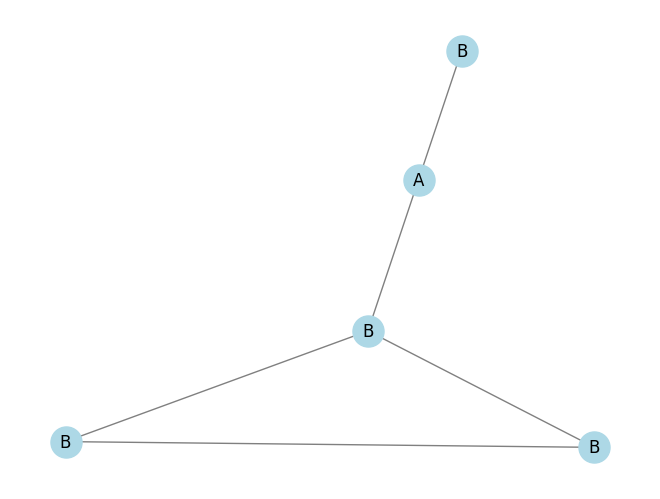

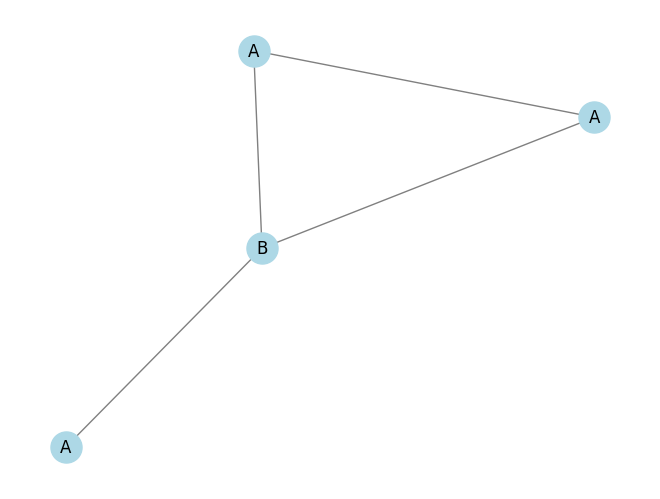

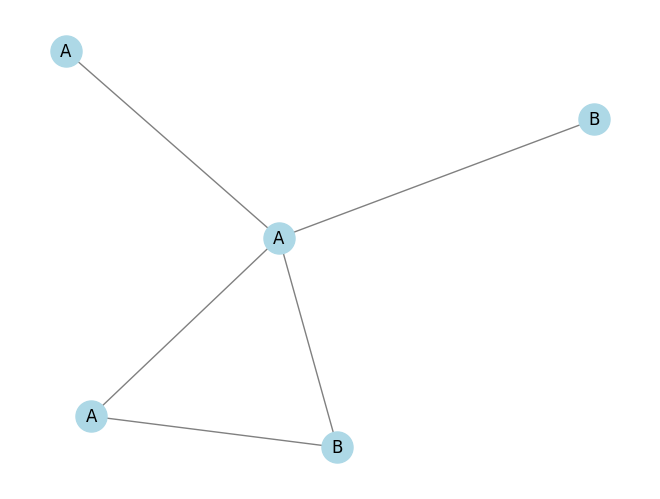

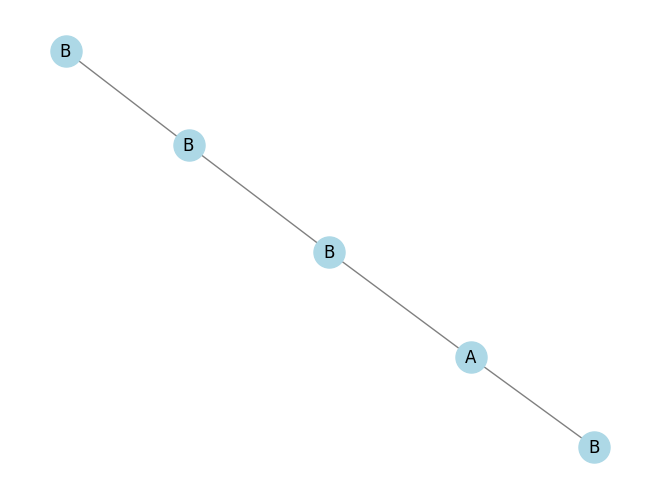

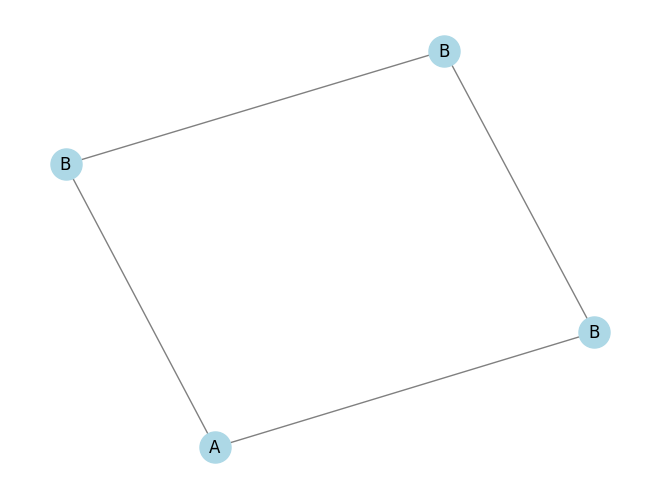

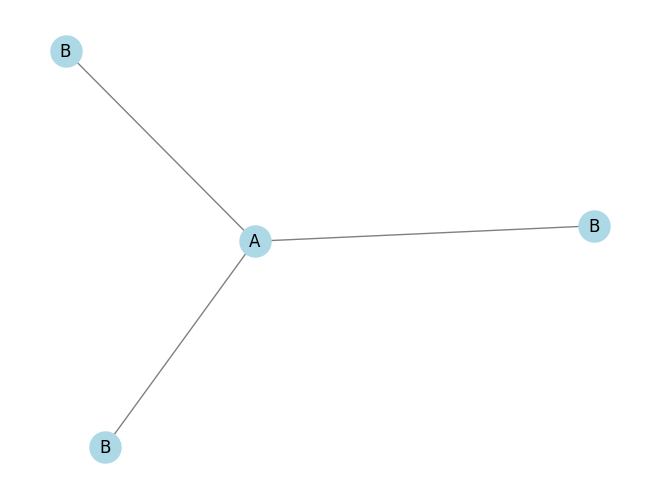

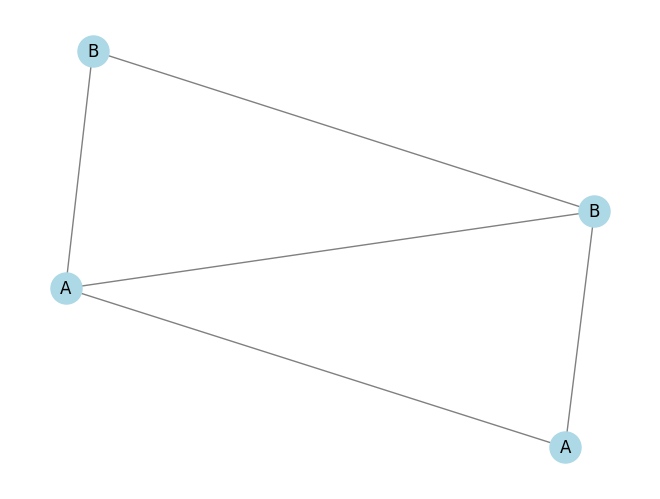

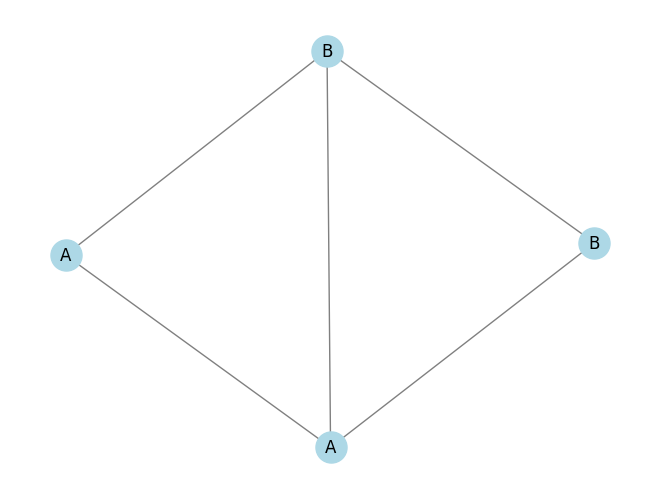

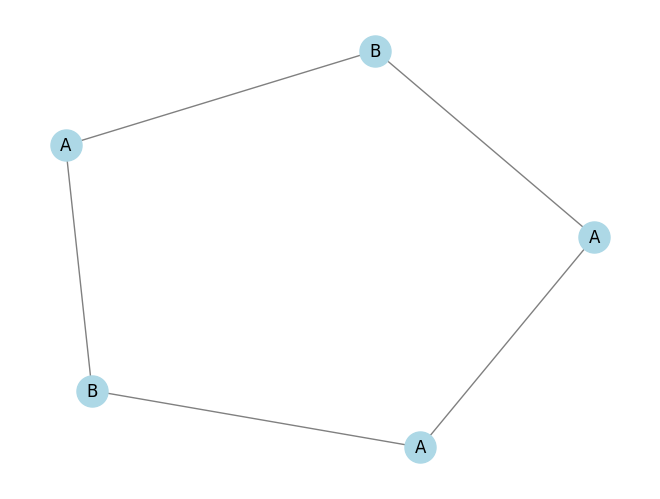

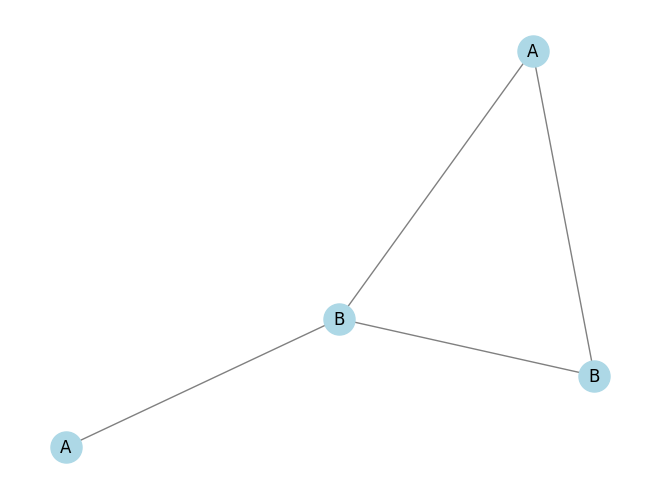

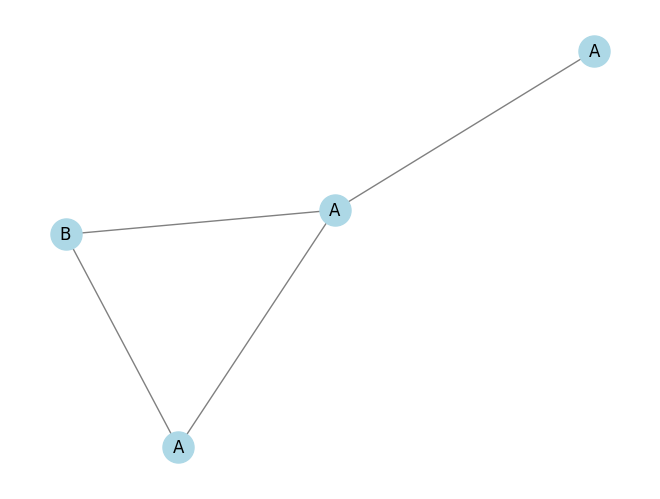

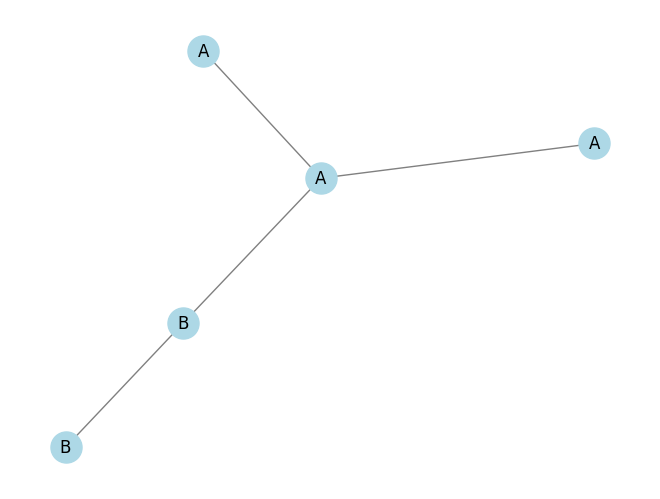

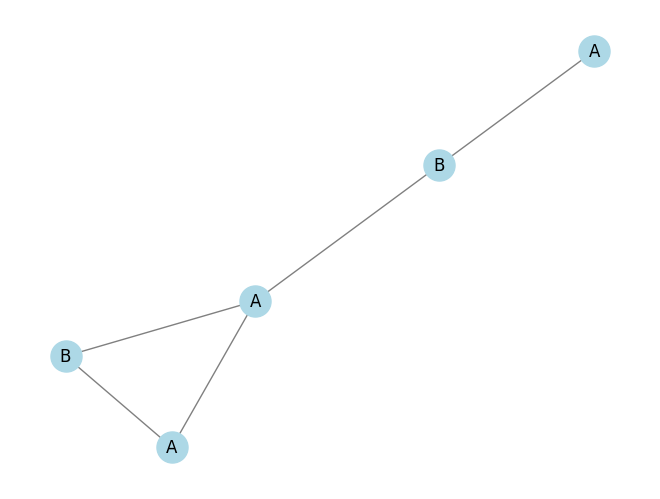

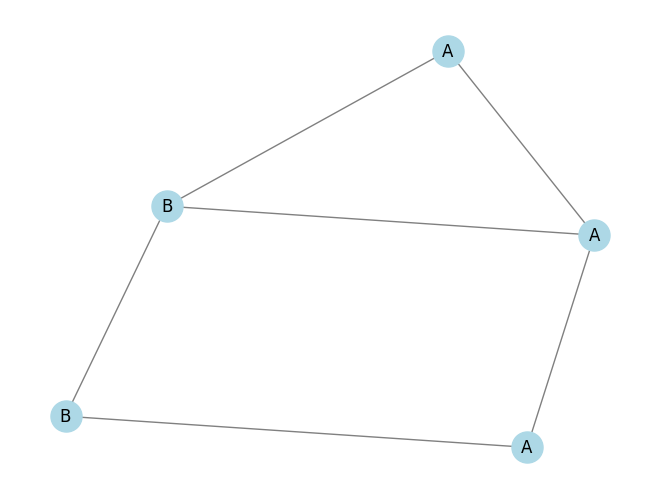

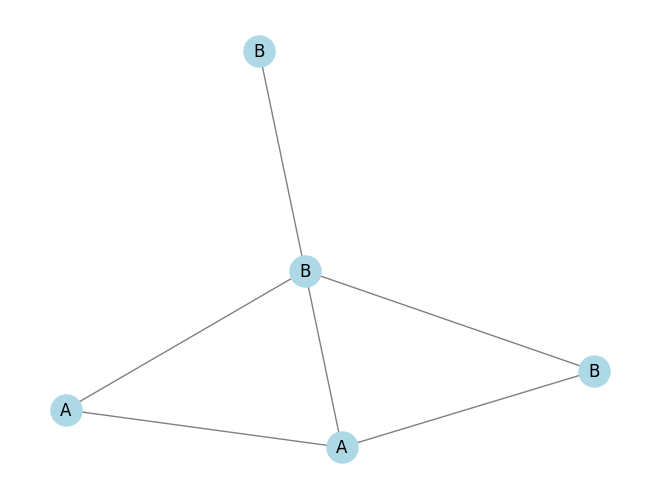

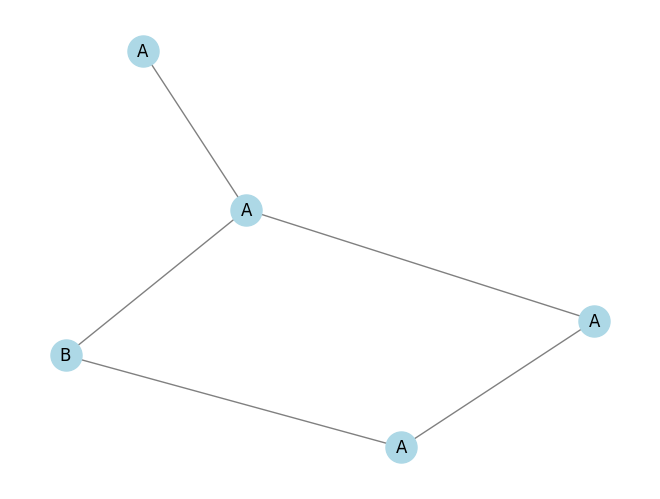

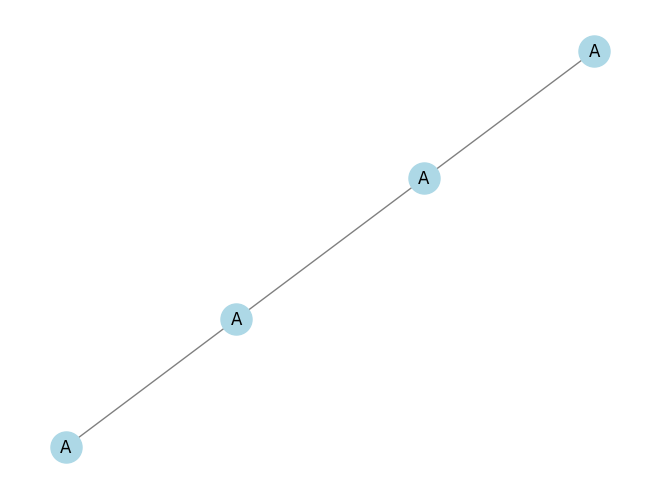

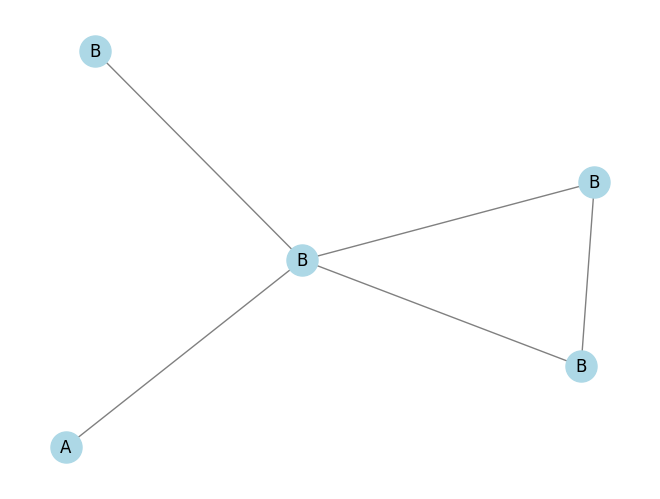

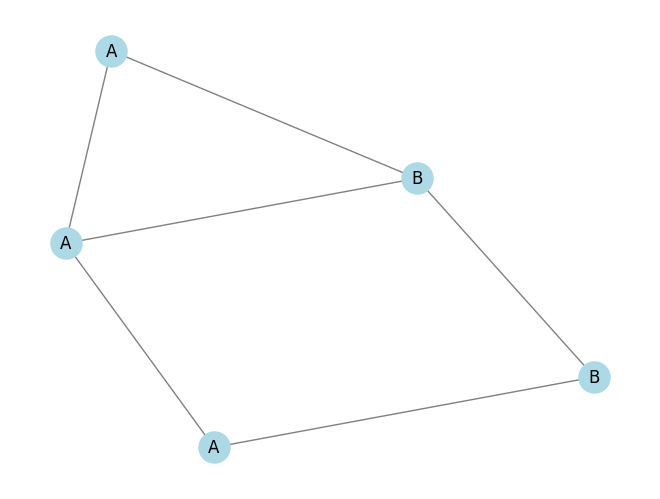

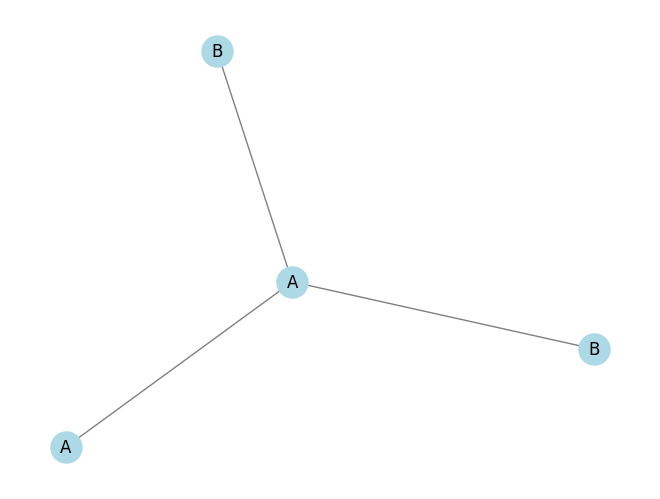

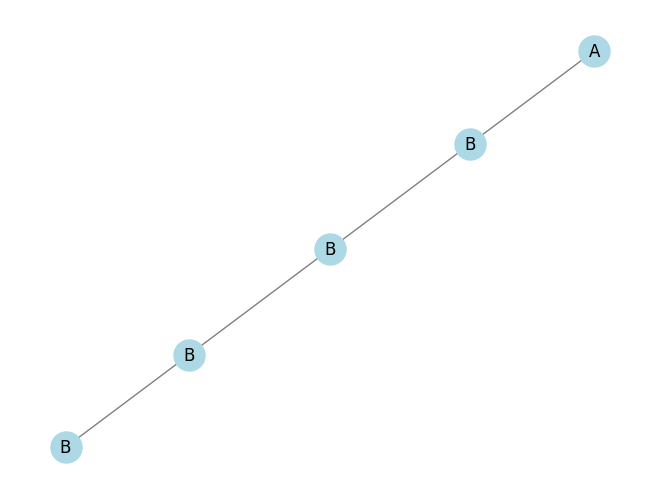

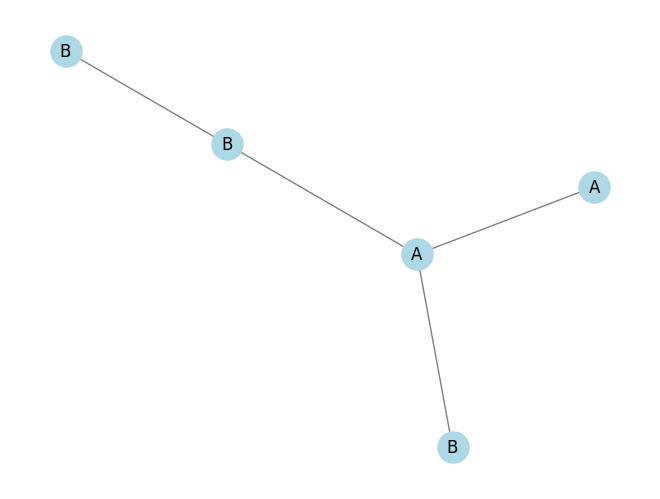

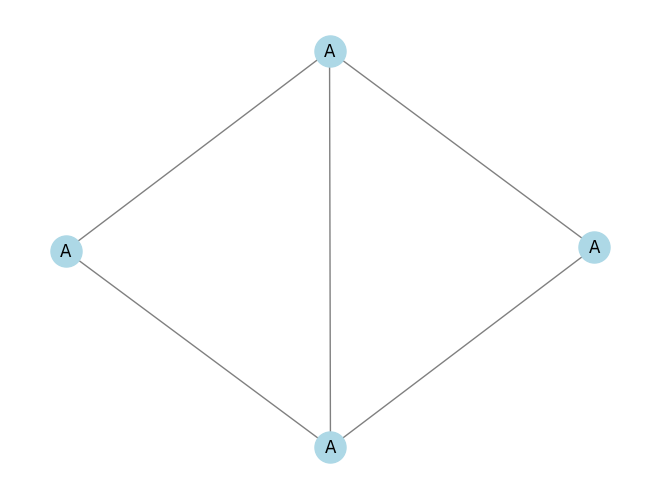

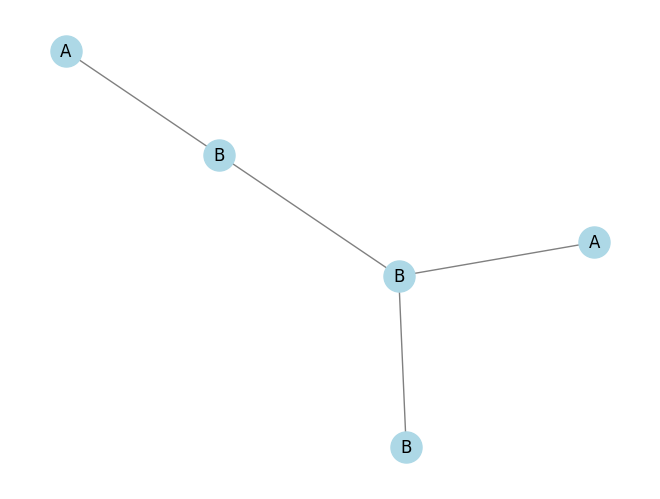

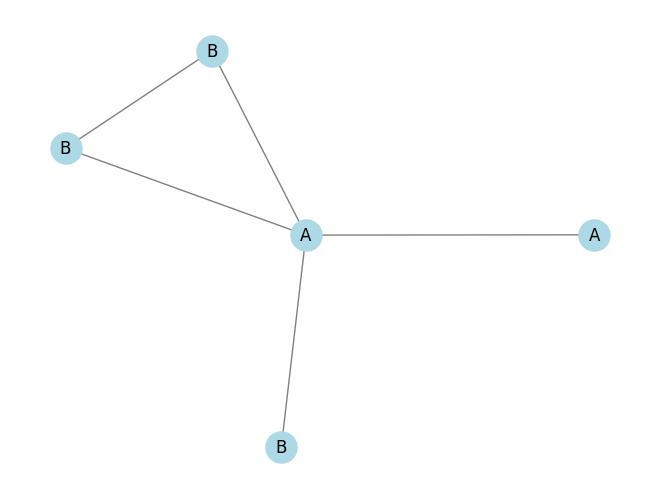

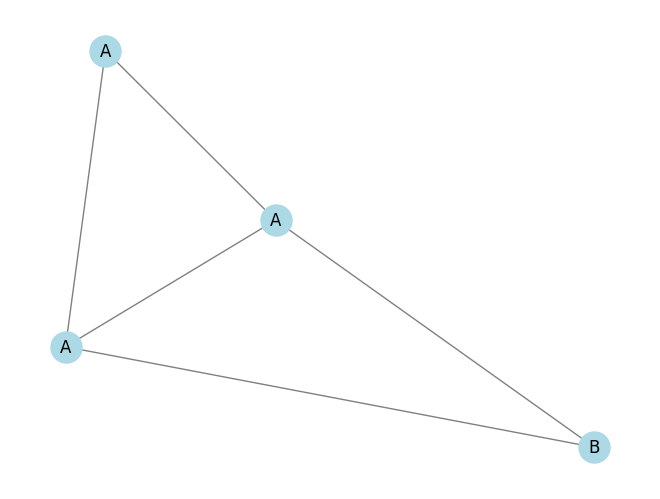

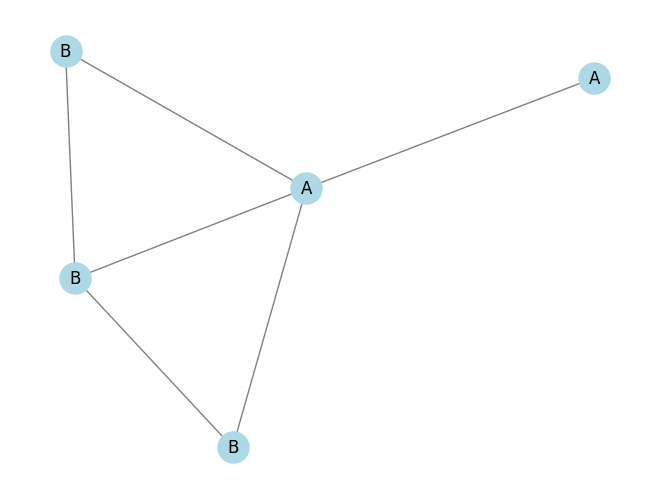

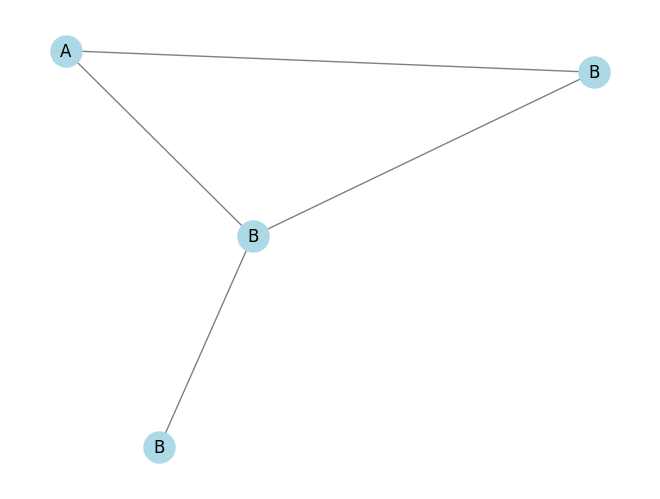

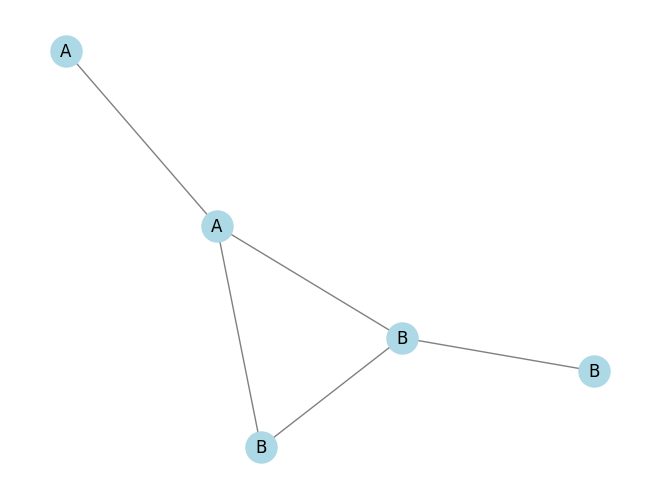

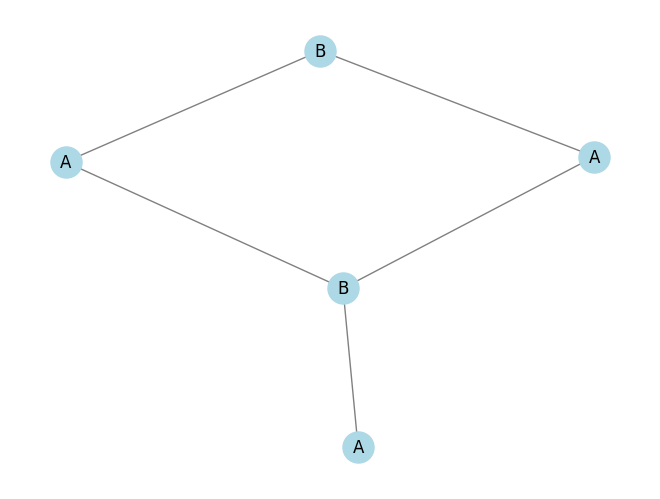

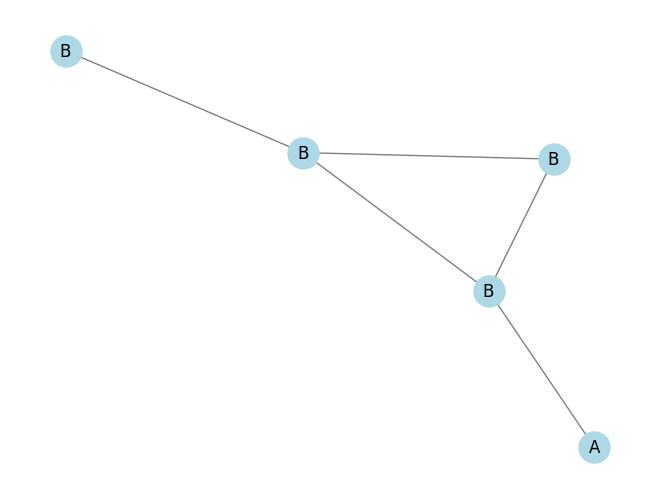

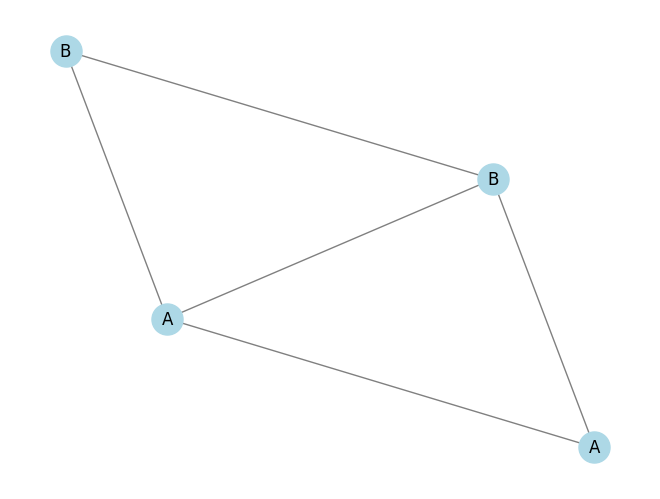

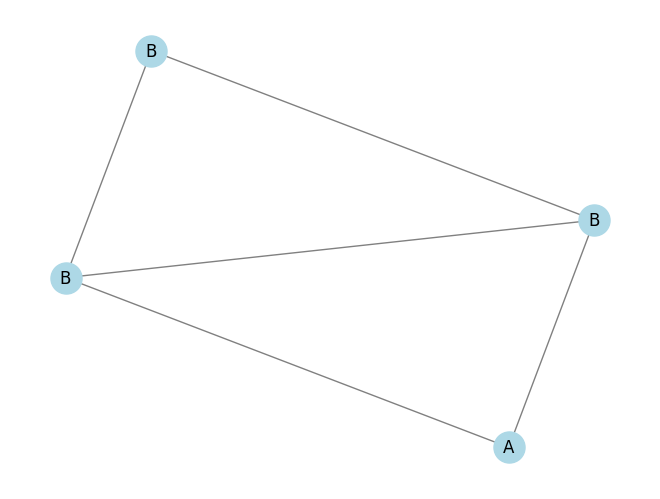

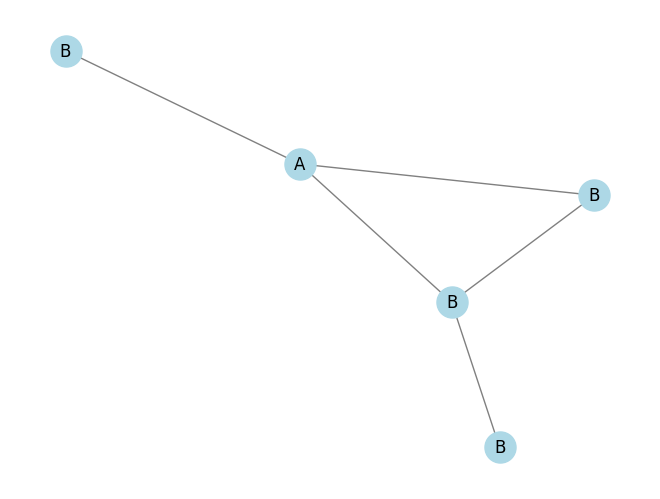

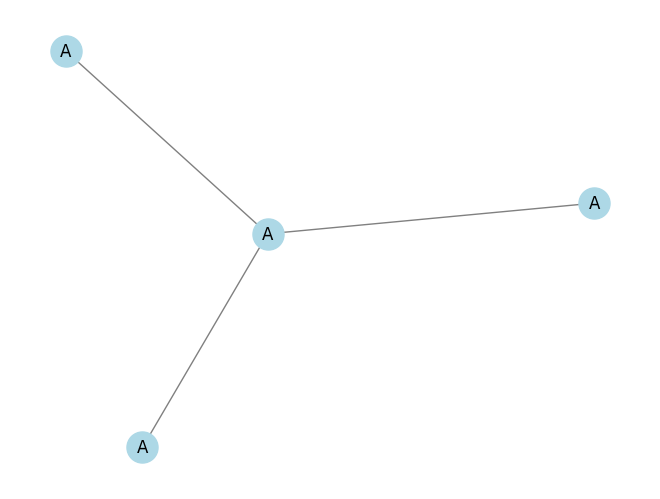

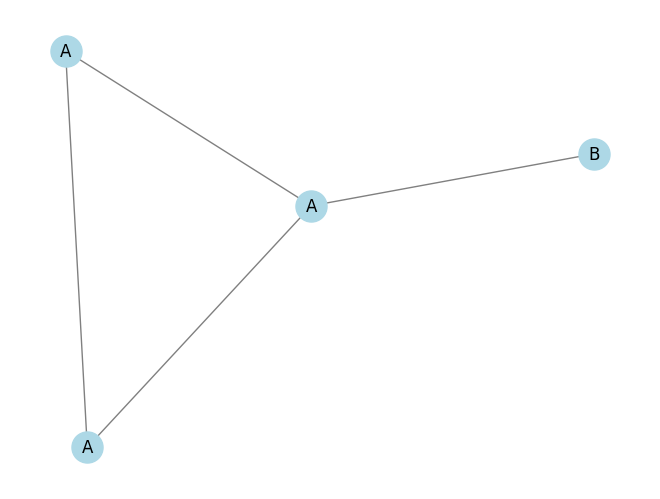

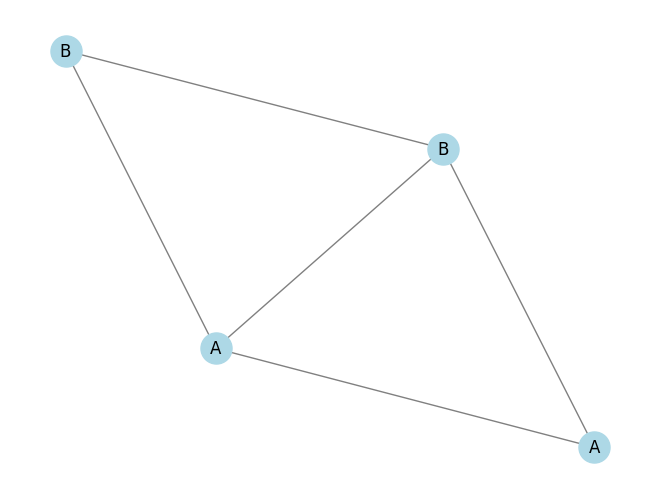

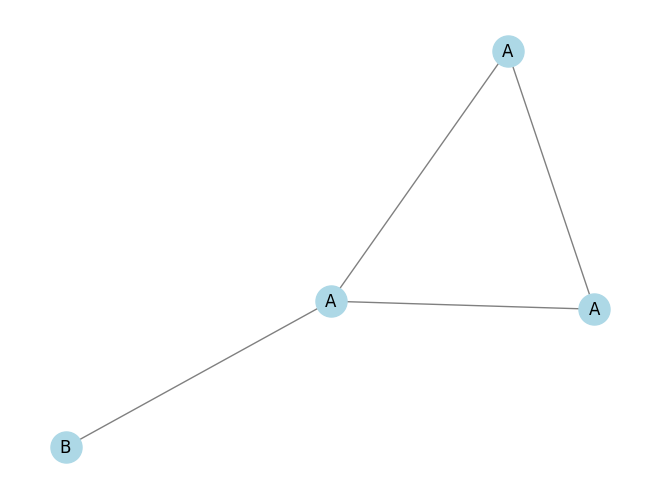

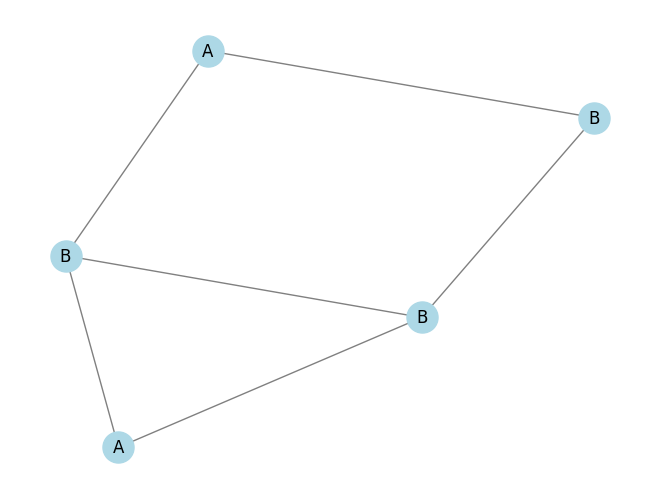

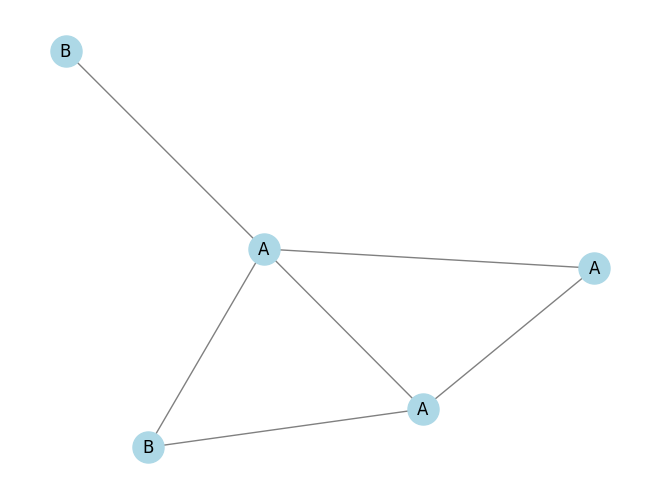

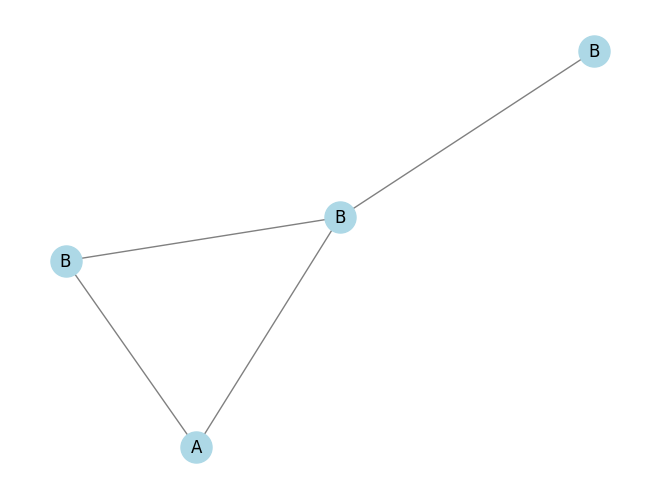

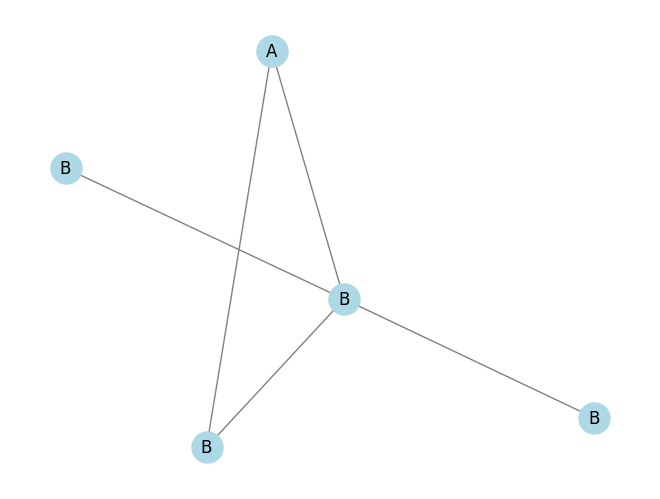

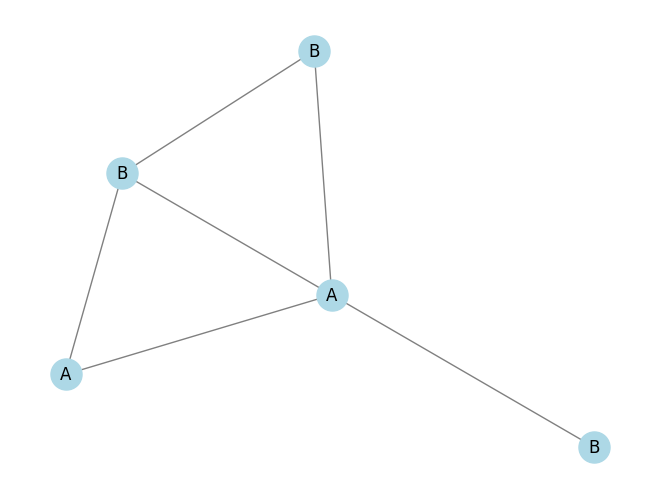

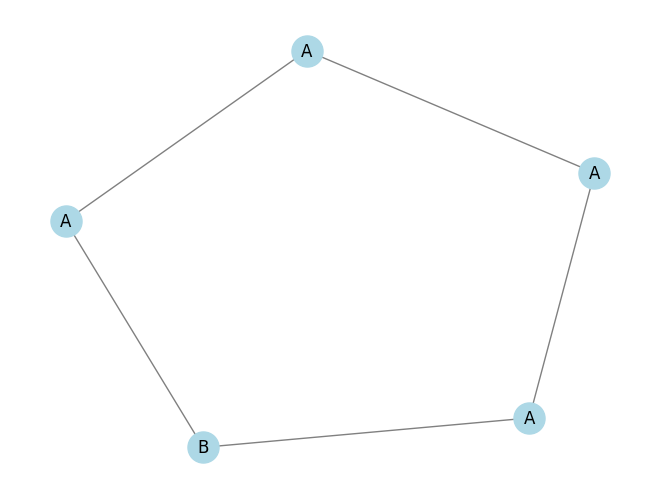

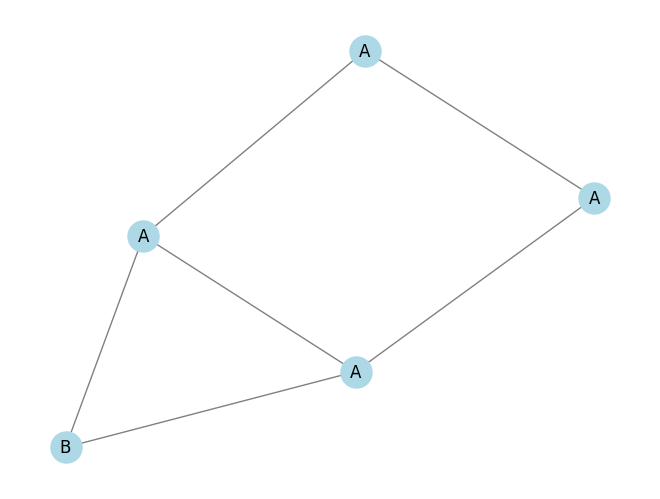

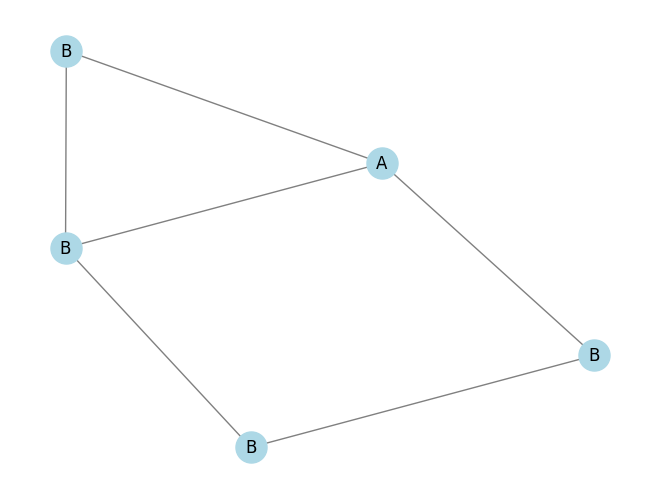

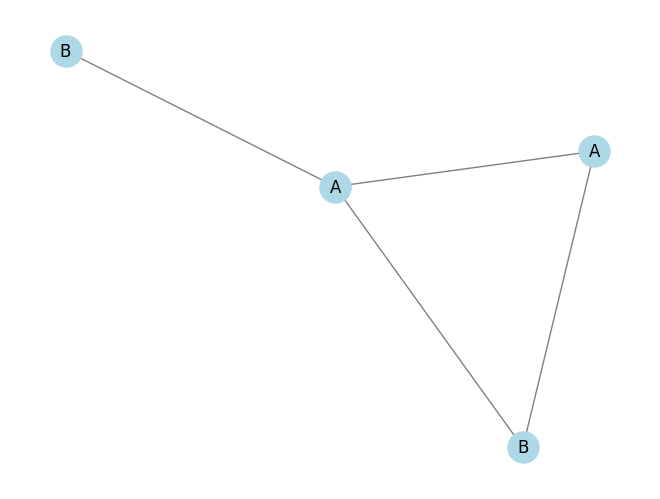

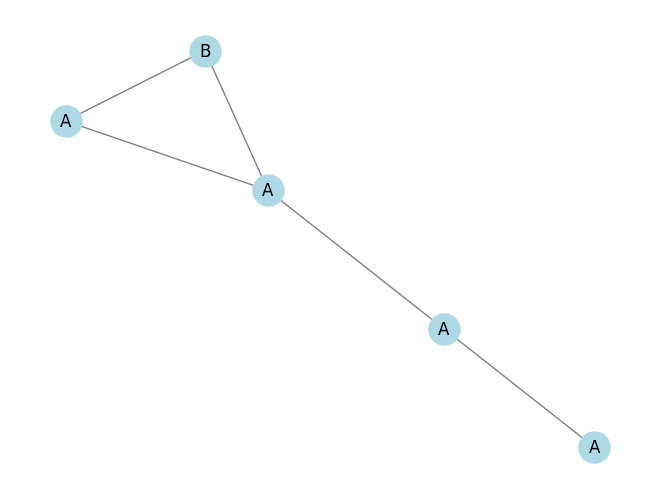

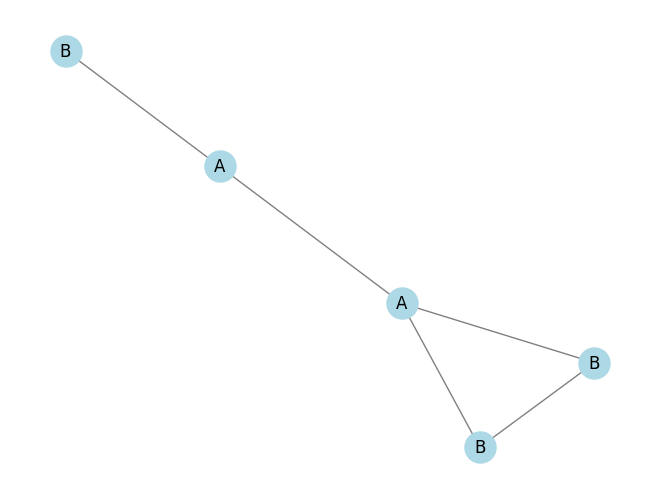

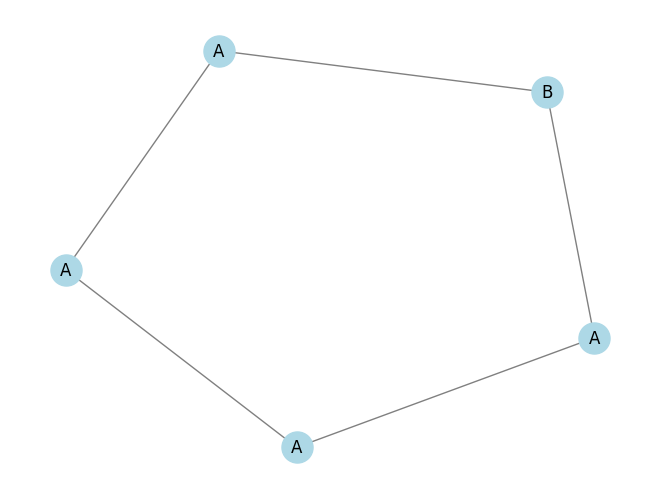

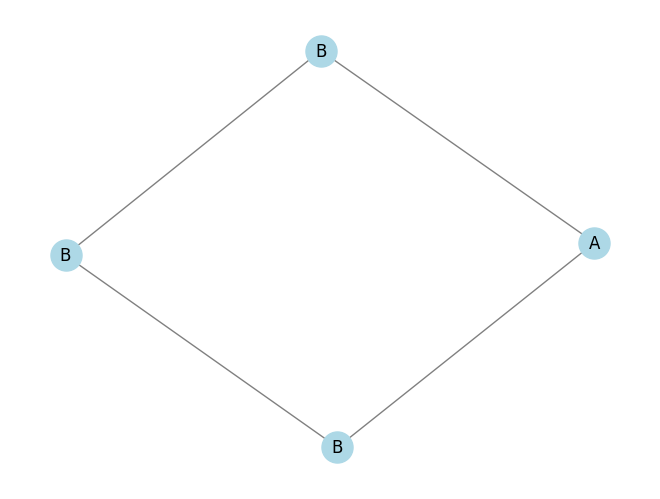

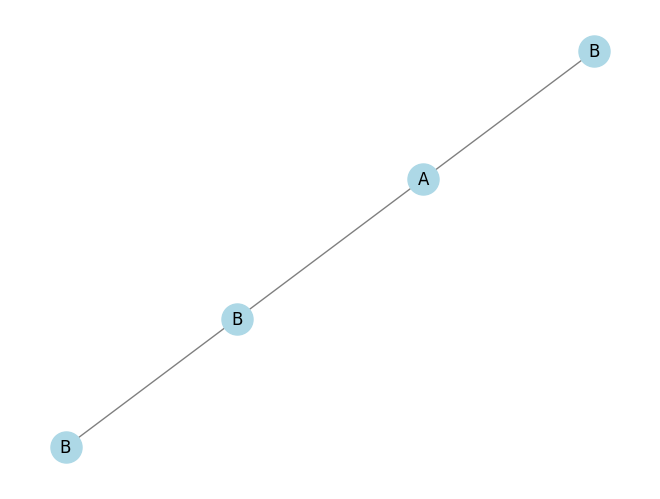

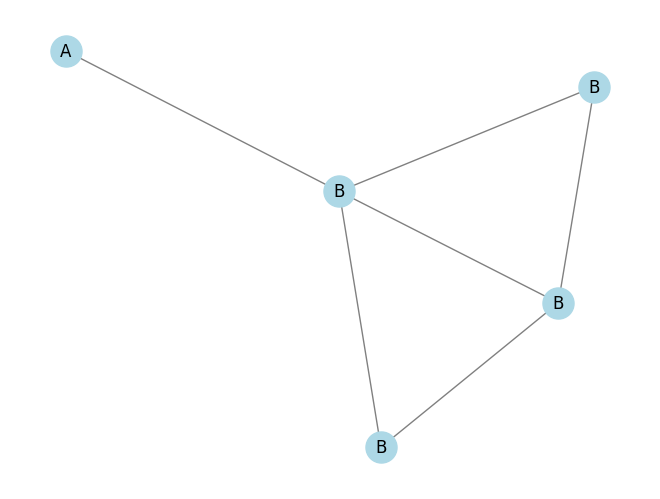

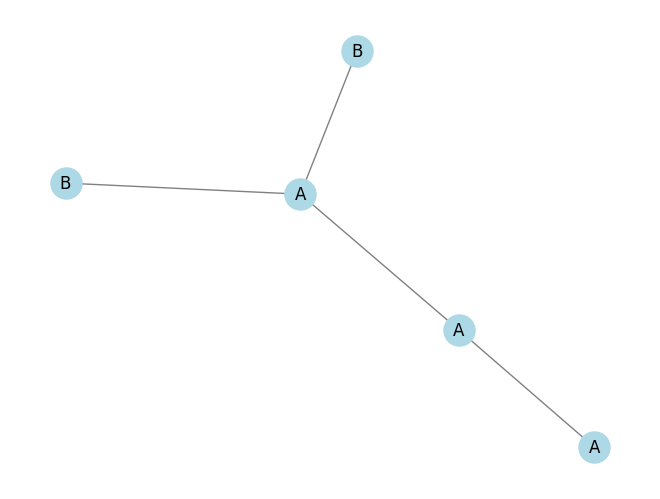

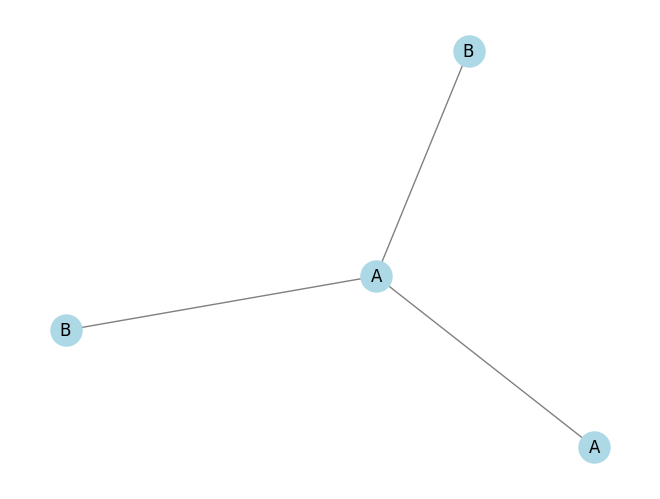

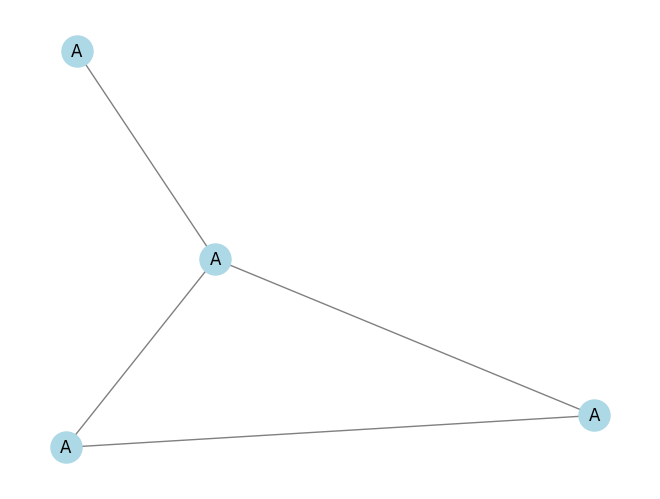

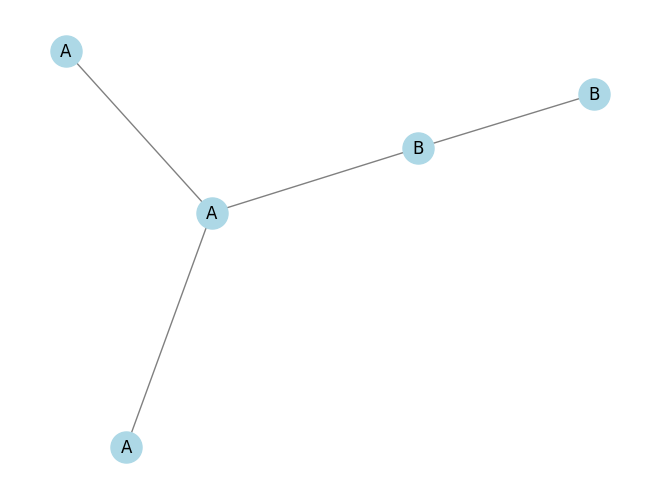

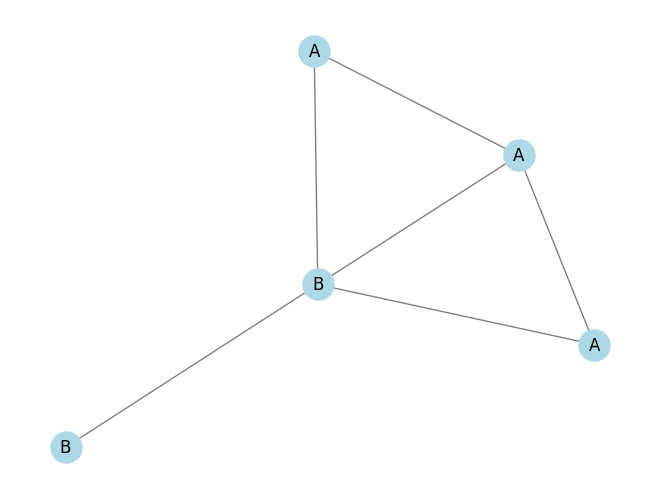

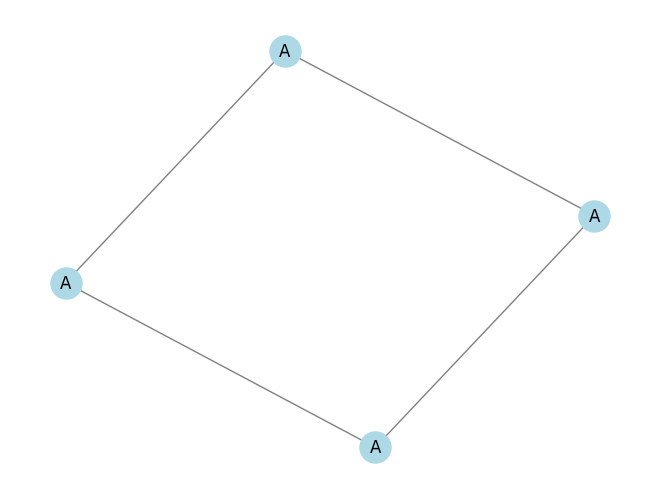

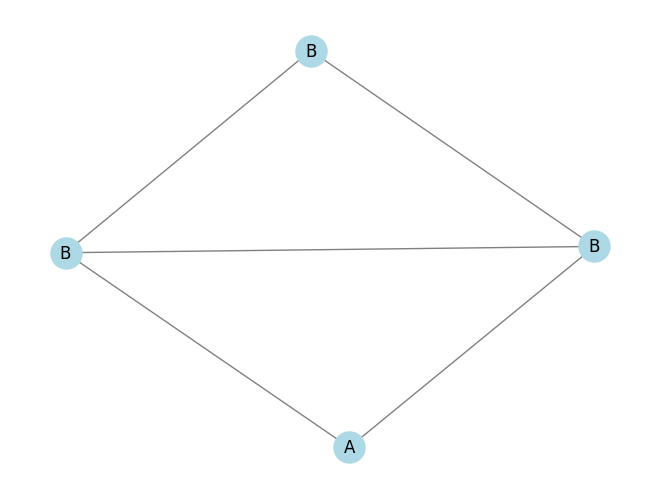

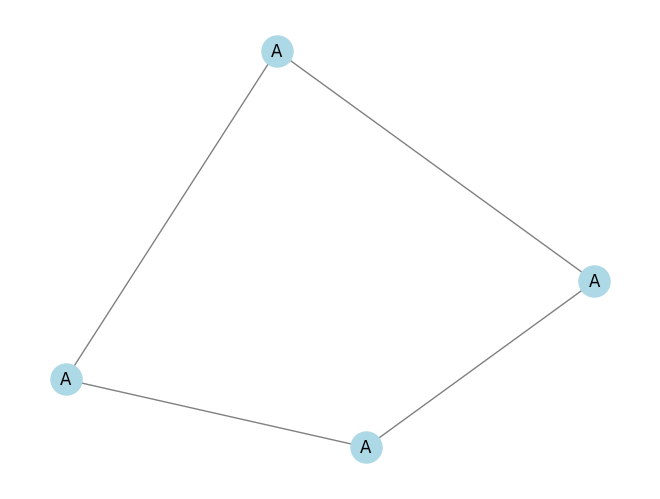

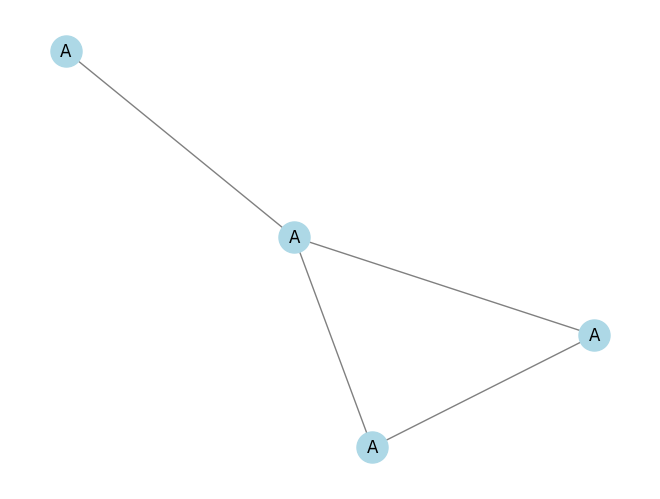

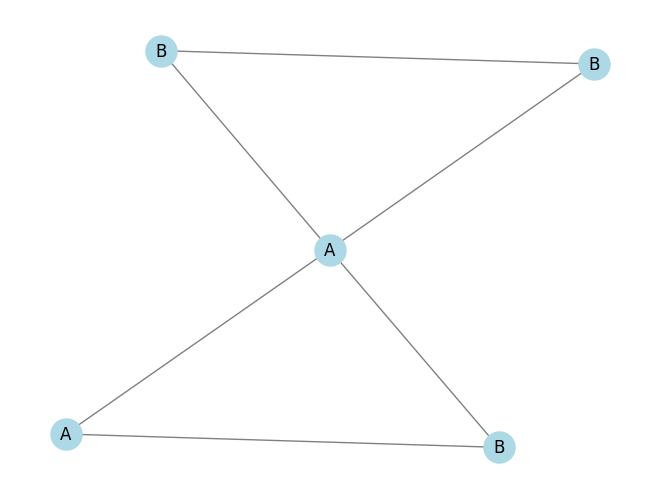

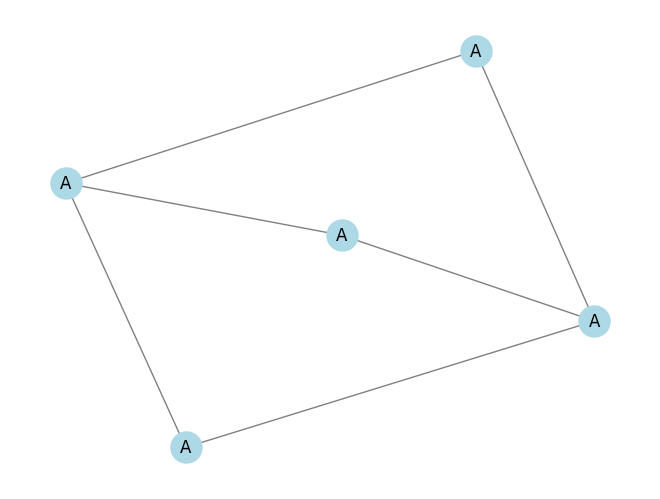

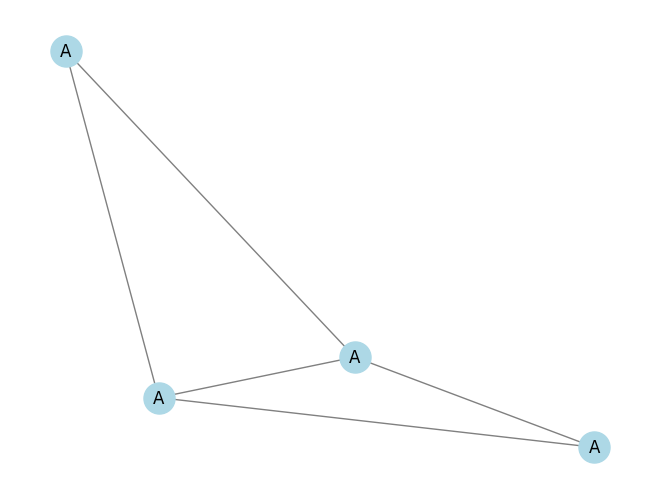

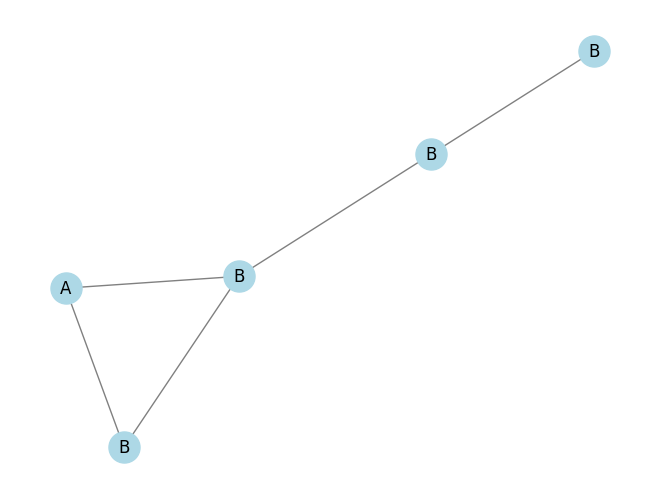

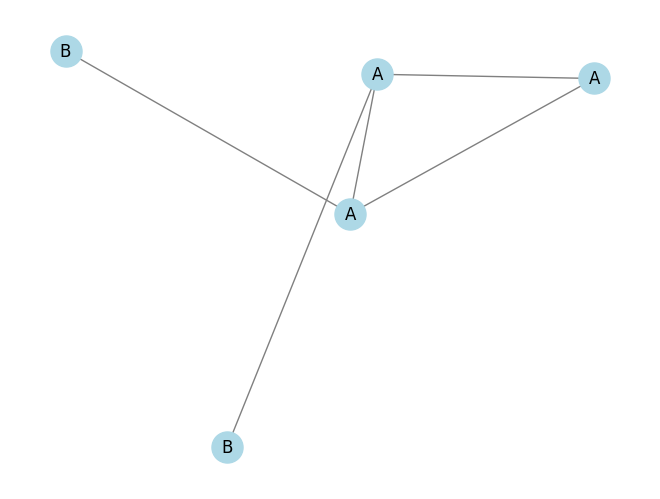

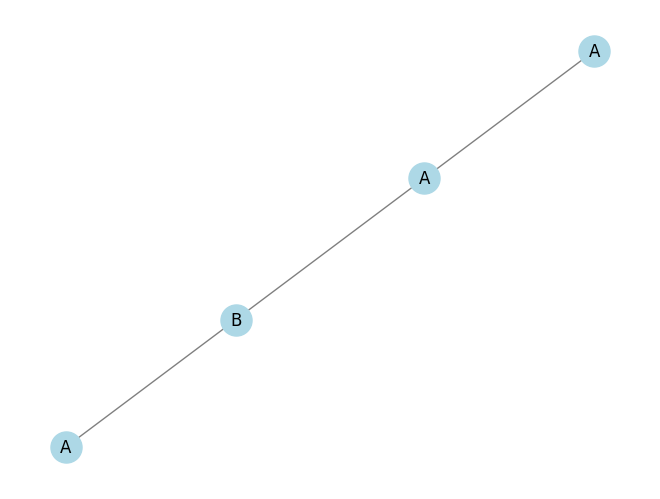

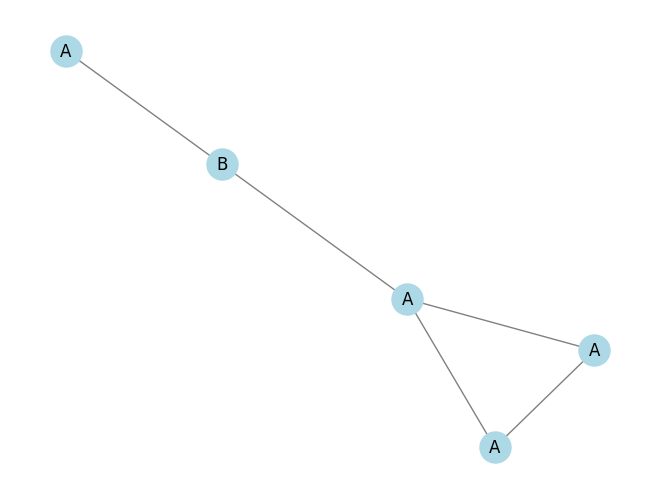

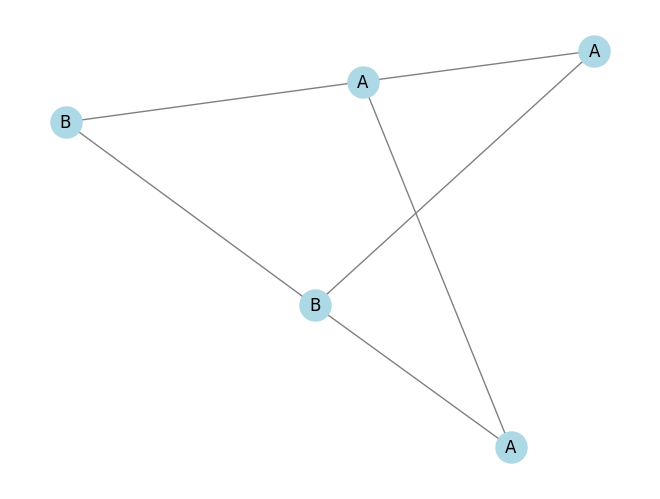

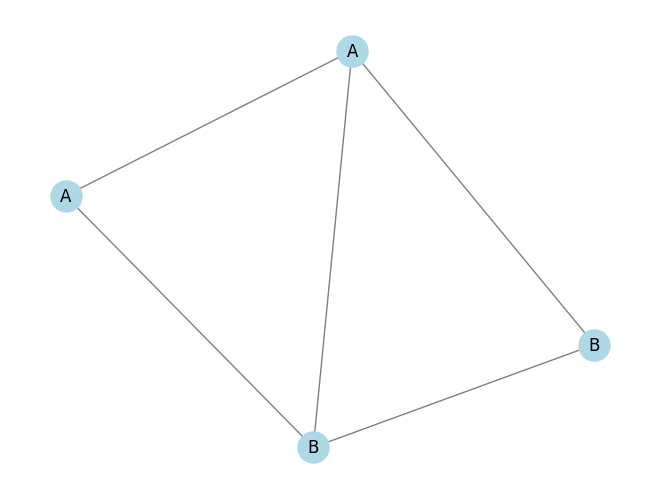

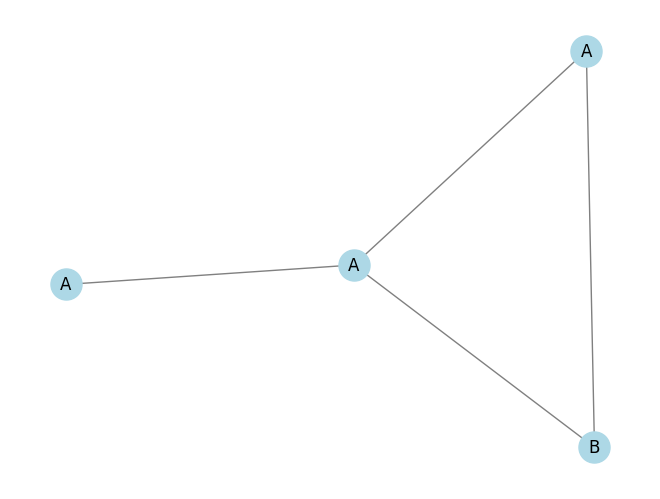

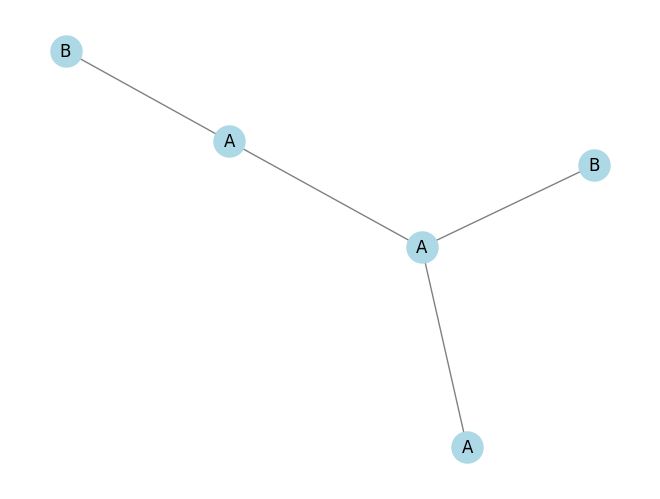

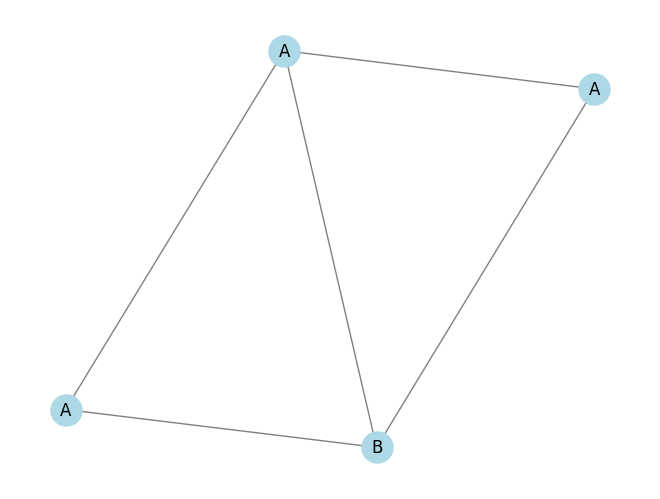

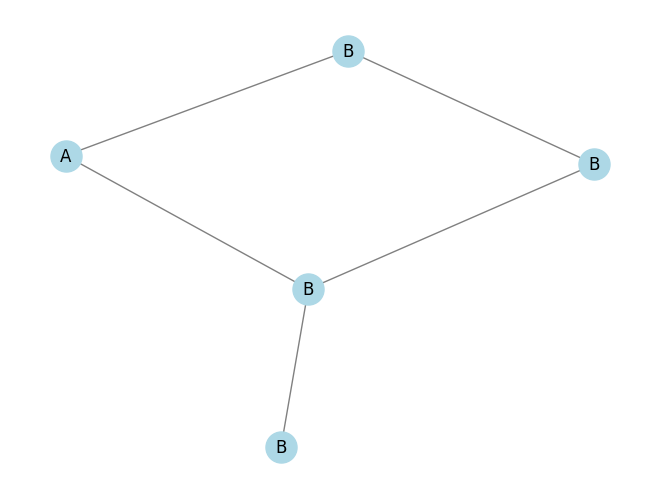

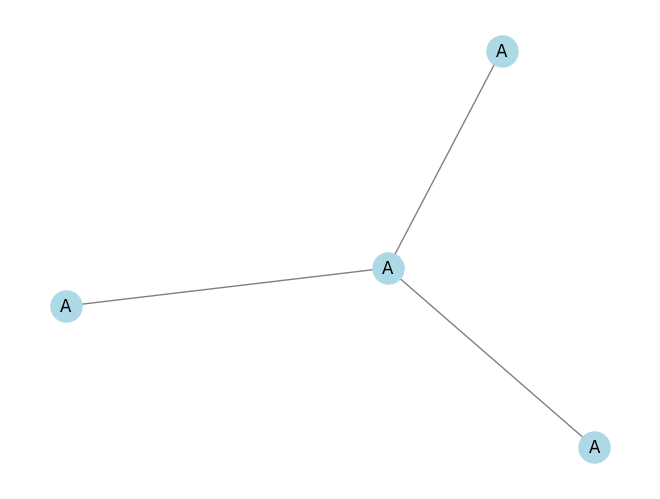

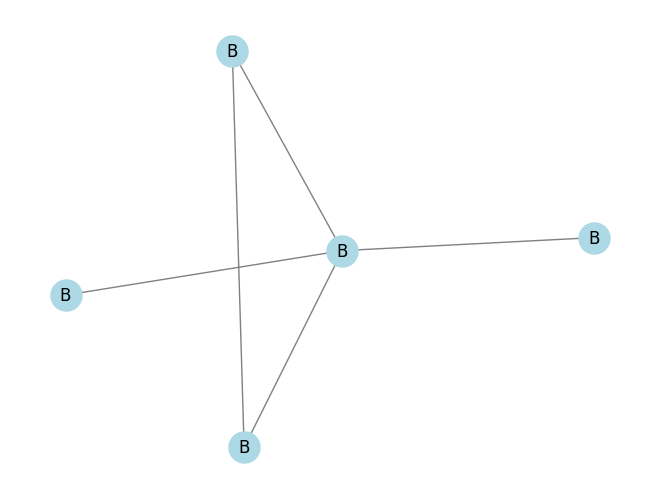

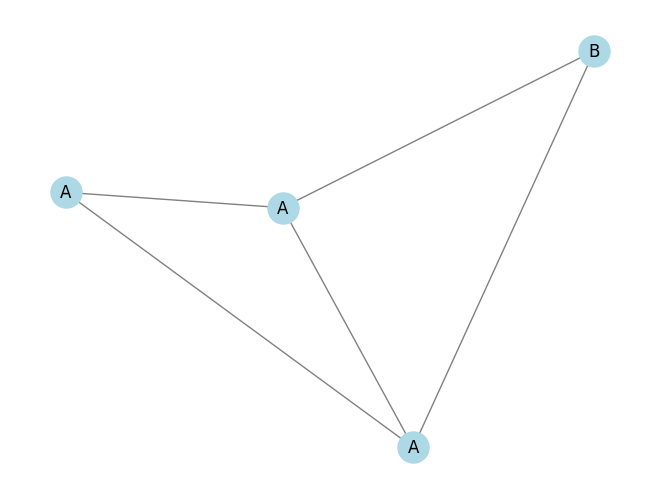

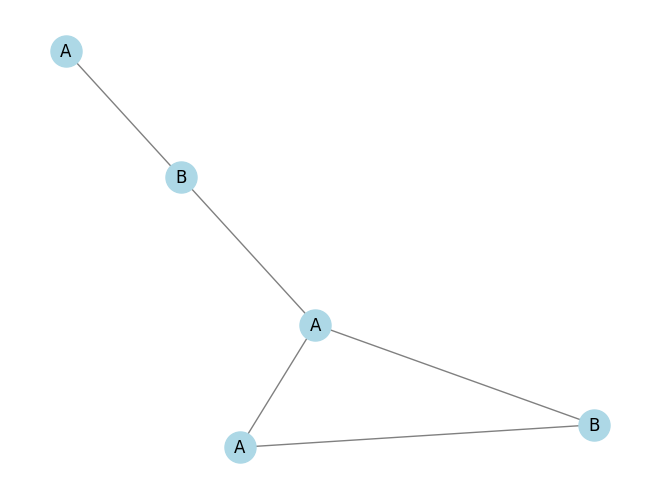

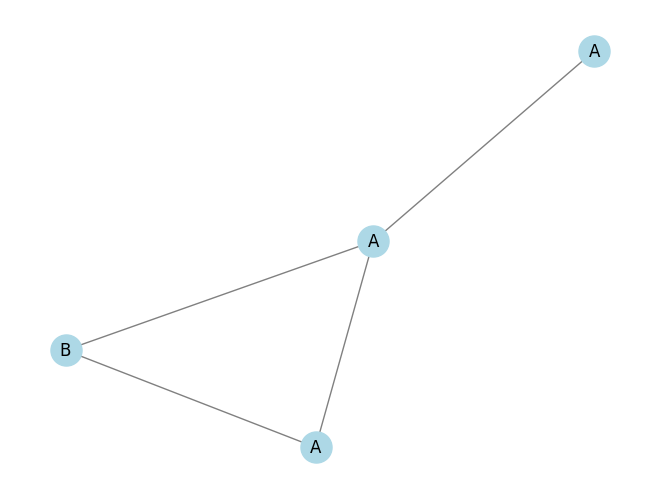

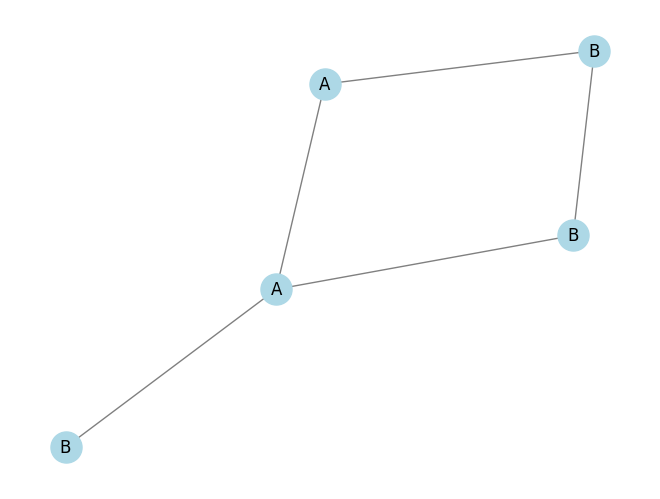

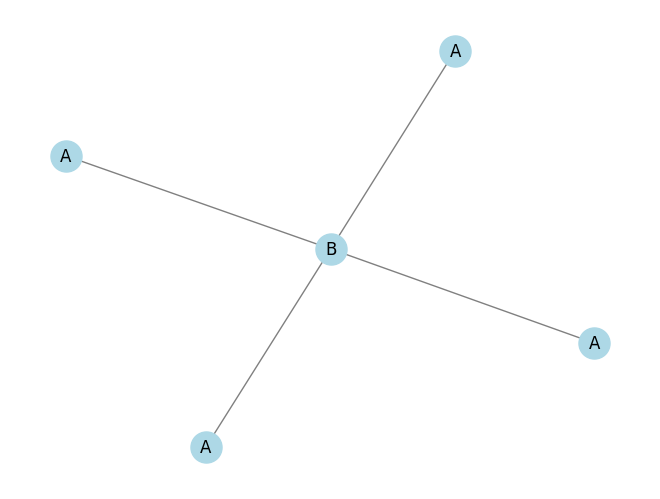

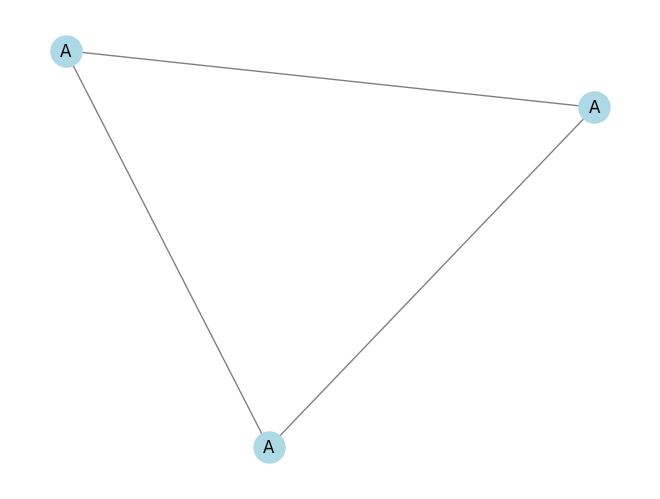

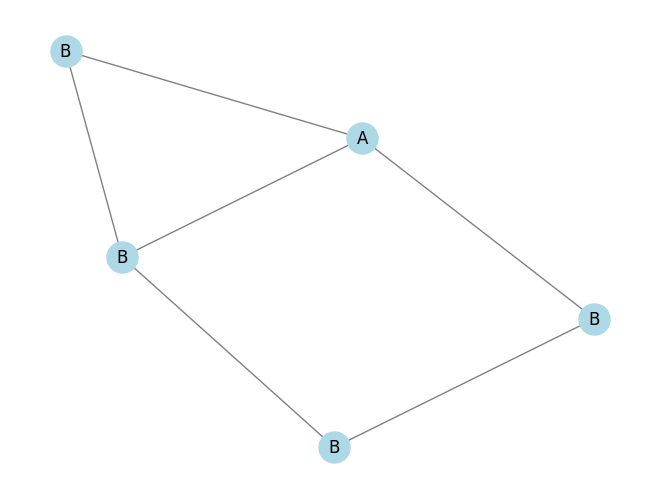

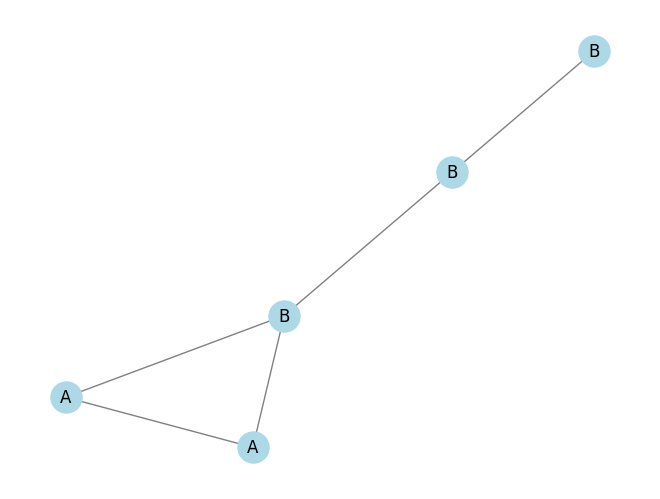

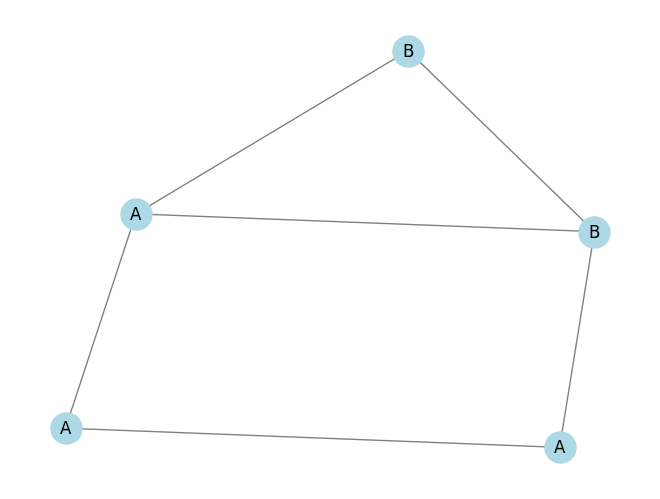

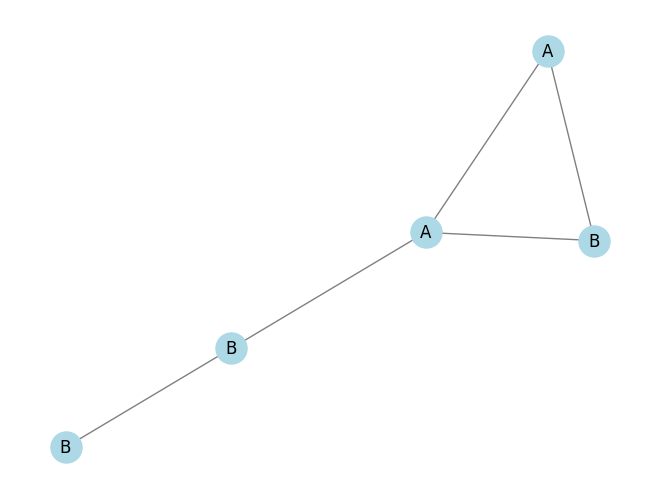

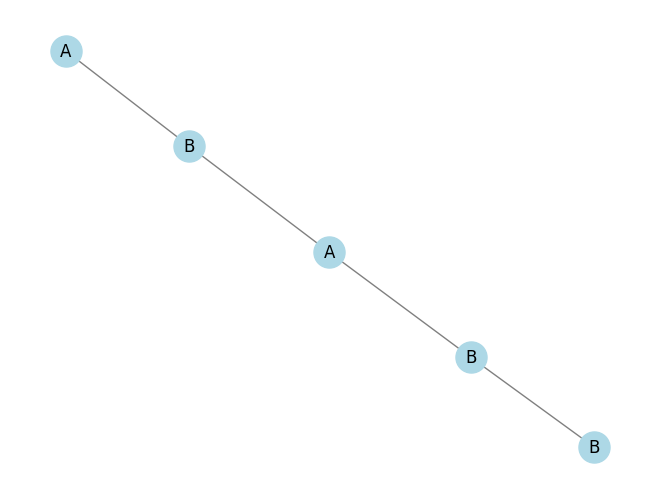

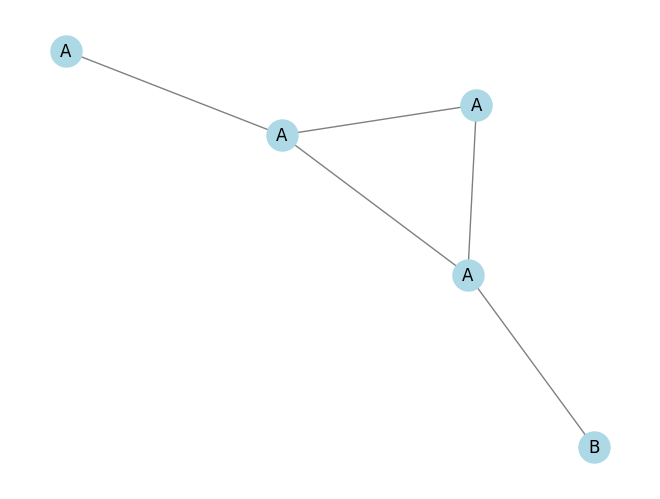

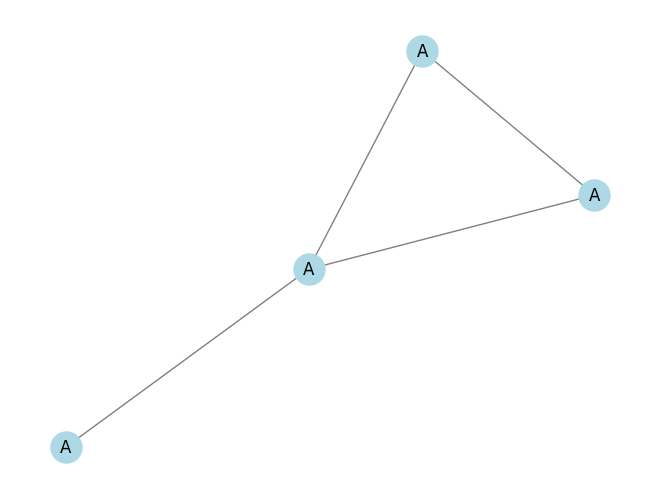

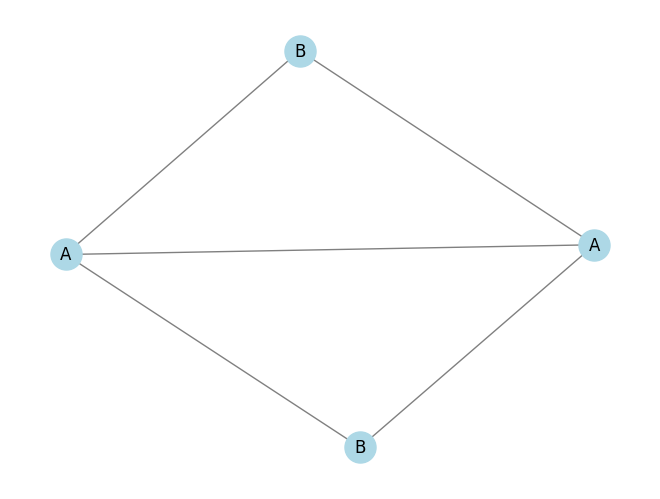

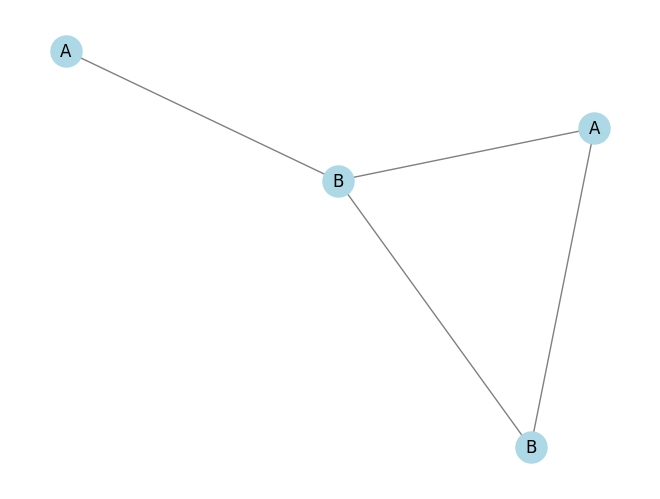

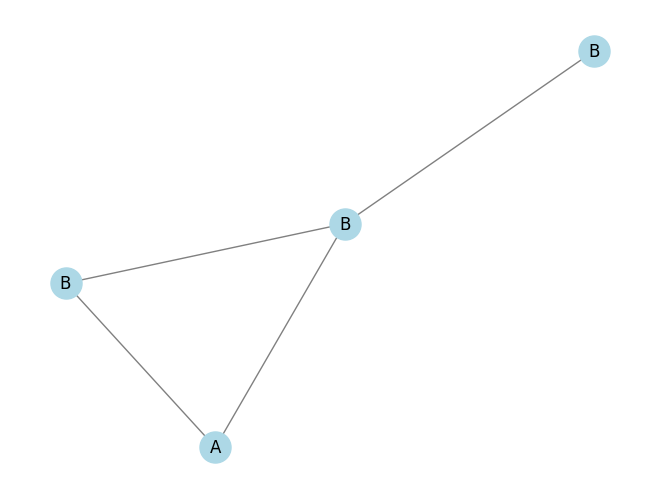

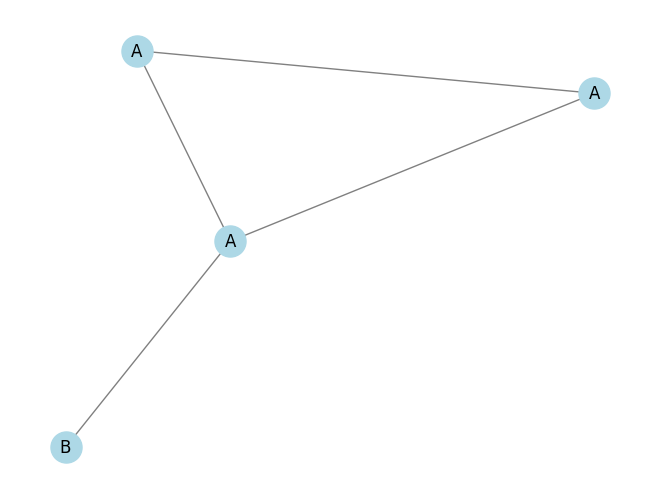

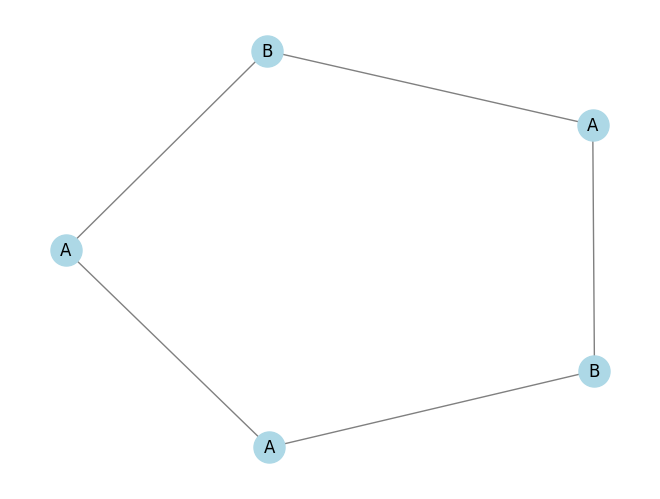

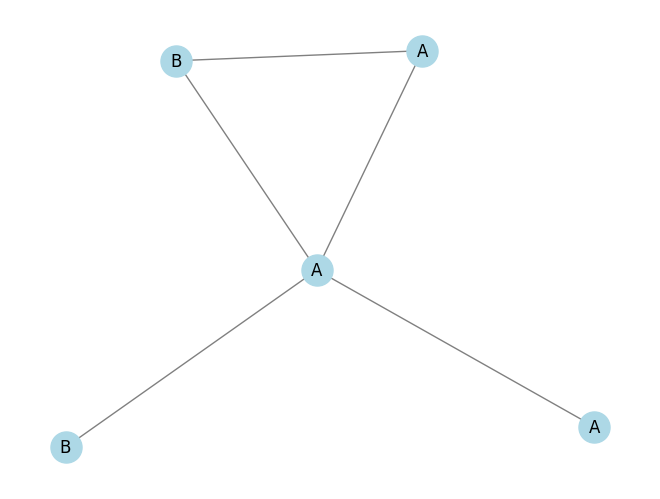

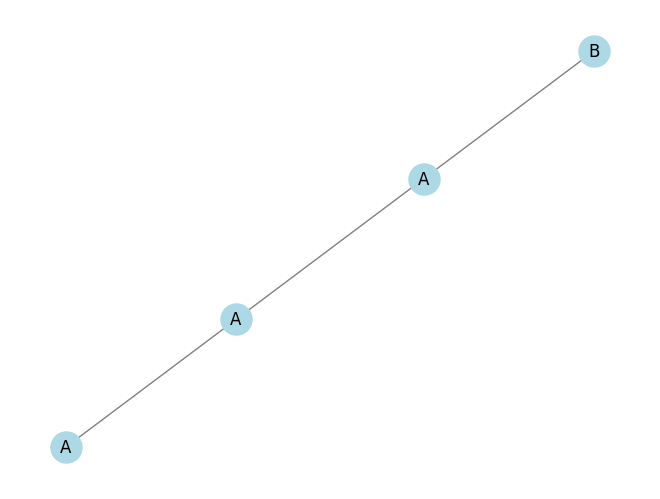

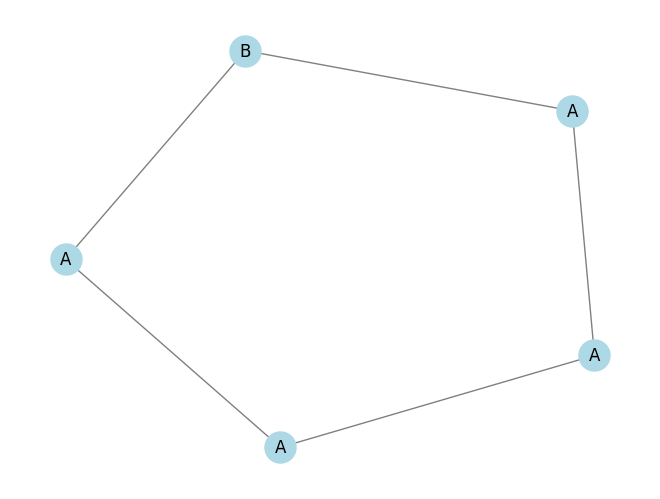

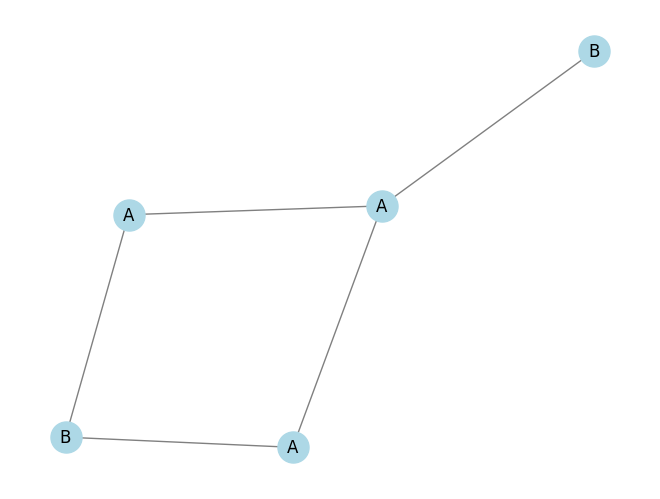

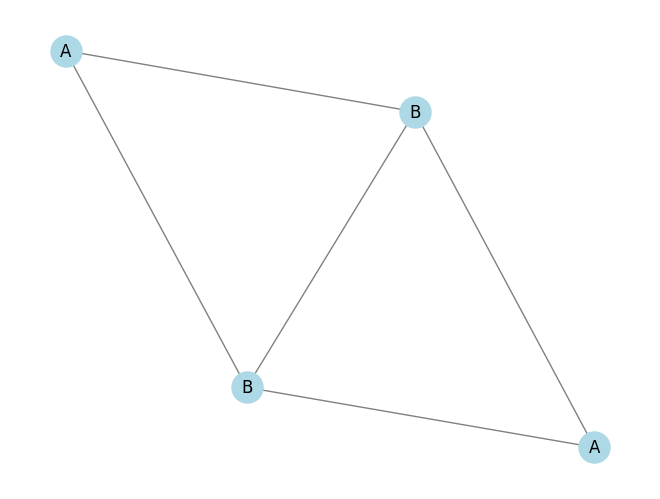

out of the last 100 graphs: 0.65 were clique 3 
out of the last 100 graphs: 0.35 were clique 2 


In [ ]:
generation_clique_count = {}
last_n_traj = 100


# Simplified visualization for each graph
for g in sampled_graphs[-last_n_traj:]:  # Loop through your graphs
    clique = len(max(nx.find_cliques(g), key=lambda clique: len(clique), default=[]))
    generation_clique_count[clique] = generation_clique_count.get(clique, 0) + 1
    graph.show_graph(g)

for key in generation_clique_count:
  print(f"out of the last {last_n_traj} graphs: {generation_clique_count[key]/last_n_traj} were clique {key} " )